In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import phik
import os
import optuna
import ast

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from optuna.integration import OptunaSearchCV 
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution


from sklearn.feature_extraction import DictVectorizer

from collections import Counter

import copy
from copy import deepcopy
from tqdm import tqdm

from statistics import multimode, mean

import logging
import warnings

# Введение

## Прадобработка данных

### apparel-purchases

In [2]:
data_purchases=pd.read_csv(filepath_or_buffer='filtered_data/apparel-purchases.csv')

In [3]:
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [4]:
data_purchases.head(5)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
data_purchases[data_purchases.duplicated(keep=False)].sort_values(by='message_id').head(4)

,client_id,quantity,price,category_ids,date,message_id
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3696,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3698,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3699,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196


- Есть дубликаты, их природа изучена далее

In [6]:
data_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

- Пропусков нет

In [7]:
# Типизация данных
data_purchases.date=pd.to_datetime(data_purchases.date)
data_purchases['client_id']=data_purchases['client_id'].astype('string')

In [8]:
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  string        
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2), string(1)
memory usage: 9.3+ MB


### apparel-messages

In [9]:
data_messages=pd.read_csv(filepath_or_buffer='filtered_data/apparel-messages.csv')

In [10]:
data_messages.head(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [11]:
#Типизация данных
data_messages.created_at=pd.to_datetime(data_messages.created_at)
data_messages.date=pd.to_datetime(data_messages.date)
data_messages['client_id']=data_messages['client_id'].astype('string')

In [12]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         string        
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3), string(1)
memory usage: 680.4+ MB


In [13]:
data_messages_dup=data_messages[data_messages.duplicated(keep=False)]
print(data_messages_dup.shape)
data_messages_dup.sort_values(by='message_id').head(10)

(94519, 7)


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
5109180,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5109179,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5651748,13308,1515915625468061100,1515915625468061100-13308-648457e227c2d,open,mobile_push,2023-06-10,2023-06-10 11:04:06
5651747,13308,1515915625468061100,1515915625468061100-13308-648457e227c2d,open,mobile_push,2023-06-10,2023-06-10 11:04:06
5609618,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37
5609617,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37
5656176,13332,1515915625468061100,1515915625468061100-13332-64848a3038e23,open,mobile_push,2023-06-10,2023-06-10 14:36:00
5656175,13332,1515915625468061100,1515915625468061100-13332-64848a3038e23,open,mobile_push,2023-06-10,2023-06-10 14:36:00
5696500,13342,1515915625468061100,1515915625468061100-13342-648873a5b5cab,open,mobile_push,2023-06-13,2023-06-13 14:19:42
5696499,13342,1515915625468061100,1515915625468061100-13342-648873a5b5cab,open,mobile_push,2023-06-13,2023-06-13 14:19:42


Дубликаты также имеются

In [14]:
data_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

- Пропусков нет

In [15]:
data_messages.channel.unique()

array(['email', 'mobile_push'], dtype=object)

In [16]:
data_messages['channel'] = data_messages['channel'].astype('category').cat.codes

email - 0 mobile_push-1

In [17]:
data_messages['channel'].unique()

array([0, 1], dtype=int8)

In [18]:
data_messages.event.unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

### target


In [19]:
data_target=pd.read_csv(filepath_or_buffer='filtered_data/apparel-target_binary.csv')

In [20]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [21]:
data_target['client_id']=data_target['client_id'].astype('string')

**Предобработка данных**

**Файл `apparel-purchases`**  
- Выполнена типизация данных:  
  - `date` → `datetime`
  - `client_id` → `string`
- Пропусков в данных нет

**Файл `apparel-messages`**  
- Выполнена типизация данных:  
  - `date` → `datetime`  
  - `created_at` → `datetime`  
  - `channel` → `bool` 
  - `client_id` → `string`
- Пропусков в данных нет

**Файл `apparel-target_binary`**
- Выполнена типизация данных:
    - `client_id` → `string`
- Пропусков в данных нет

## Исследовательский анализ данных

### Дубликаты в данных

In [22]:
data_messages_dup=data_messages[data_messages.duplicated(keep=False)]

In [23]:
sum_event_dup = pd.pivot_table(
    data=data_messages_dup,
    index=['message_id'],
    columns=['event'],
    values='client_id' ,
    aggfunc='count',
    fill_value=0
)
sum_event_dup.head(5)

event,click,complain,hard_bounce,open,purchase,send,soft_bounce,unsubscribe
message_id,,,,,,,,
1515915625468061003-12566-646330138e845,2,0,0,0,0,0,0,0
1515915625468061100-13308-648457e227c2d,0,0,0,2,0,0,0,0
1515915625468061100-13324-648403889887c,0,0,0,2,0,0,0,0
1515915625468061100-13332-64848a3038e23,0,0,0,2,0,0,0,0
1515915625468061100-13342-648873a5b5cab,0,0,0,2,0,0,0,0


In [24]:
sum_event_dup.sum()

event
click          25204
complain           2
hard_bounce      257
open           65402
purchase        3595
send              44
soft_bounce        2
unsubscribe       13
dtype: int64

Дубликаты встречаются при каждом действии

#### Провека дубликатов purchase 

In [25]:
dpgm = data_purchases.groupby('message_id')['quantity'].agg(('sum','count'))
dpgm=dpgm.reset_index()
dpgm.columns=['message_id', 'p_sum','p_count']
dpgm.head(5)

,message_id,p_sum,p_count
0,1515915625468060902-4617-6290657dac196,7,7
1,1515915625468061003-9148-63b54b04855a4,7,7
2,1515915625468061099-4439-62834141aa538,1,1
3,1515915625468061100-14623-65c5c55eeb9e0,2,2
4,1515915625468061170-11144-641ad2cda77a2,4,4


In [26]:
data_purchases.query('message_id == "1515915625468060902-4617-6290657dac196"')

,client_id,quantity,price,category_ids,date,message_id
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3696,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3697,1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196
3698,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3699,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3700,1515915625468060902,1,299.0,"['4', '28', '290', '422']",2022-05-27,1515915625468060902-4617-6290657dac196
3701,1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196


In [27]:
data_messages.query('message_id == "1515915625468073343-4710-6299a5ac6fac7"')

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
225809,4710,1515915625468073343,1515915625468073343-4710-6299a5ac6fac7,send,0,2022-06-03,2022-06-03 06:18:09
239754,4710,1515915625468073343,1515915625468073343-4710-6299a5ac6fac7,open,0,2022-06-03,2022-06-03 09:13:45
239768,4710,1515915625468073343,1515915625468073343-4710-6299a5ac6fac7,click,0,2022-06-03,2022-06-03 09:15:23
239786,4710,1515915625468073343,1515915625468073343-4710-6299a5ac6fac7,click,0,2022-06-03,2022-06-03 09:17:34
239853,4710,1515915625468073343,1515915625468073343-4710-6299a5ac6fac7,purchase,0,2022-06-03,2022-06-03 09:25:29


In [28]:
data_messages.query('message_id == "1515915625543282449-9737-63d8d0118f8d0"')

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
3837504,9737,1515915625543282449,1515915625543282449-9737-63d8d0118f8d0,send,0,2023-01-31,2023-01-31 10:50:51
3843012,9737,1515915625543282449,1515915625543282449-9737-63d8d0118f8d0,open,0,2023-01-31,2023-01-31 15:54:46
3843105,9737,1515915625543282449,1515915625543282449-9737-63d8d0118f8d0,click,0,2023-01-31,2023-01-31 15:55:18
3844485,9737,1515915625543282449,1515915625543282449-9737-63d8d0118f8d0,purchase,0,2023-01-31,2023-01-31 16:04:17
3844486,9737,1515915625543282449,1515915625543282449-9737-63d8d0118f8d0,purchase,0,2023-01-31,2023-01-31 16:04:17


In [29]:
data_purchases.query('message_id == "1515915625543282449-9737-63d8d0118f8d0"') #Сообщение имеет дубликат в data_messages

,client_id,quantity,price,category_ids,date,message_id
84255,1515915625490189192,1,700.0,"['4', '28', '249', '615']",2023-01-31,1515915625543282449-9737-63d8d0118f8d0
84256,1515915625490189192,1,999.0,"['4', '28', '249', '615']",2023-01-31,1515915625543282449-9737-63d8d0118f8d0


- Дубликаты в data_purchases обусловлены особеностью записи, покупки одних и тех же товаров в течении дня приведет к образованию дубликата, следовательно можно сгрупировтаь дубликаты по price	category_ids	date	message_id 
- Дубликаты в data_messages, как минимум при event=purchase могут быть обусловлены покупкой разных товаров в один момент

In [30]:
#Группировка data_purchases для устранения дубликатов
data_purchases=data_purchases.groupby(['message_id','client_id','price', 'category_ids', 'date']).sum().reset_index()
data_purchases.duplicated().sum()

0

In [31]:
#Типизация для дальнейшего преобразования
data_purchases['category_ids']=data_purchases['category_ids'].apply(lambda x: ast.literal_eval(x))

In [32]:
#Учет количества товара в category_ids
data_purchases['category_ids']=data_purchases['category_ids']*data_purchases['quantity']

#### Остальные дубликаты в data_messages

In [33]:
sum_event_dup.sort_values(by='open',ascending=False).head(3)

event,click,complain,hard_bounce,open,purchase,send,soft_bounce,unsubscribe
message_id,,,,,,,,
1515915625491647467-13842-650945956b0dc,0,0,0,20,0,0,0,0
1515915625491647467-12218-644b829a5e361,0,0,0,14,0,0,0,0
1515915625473351555-11952-643e79294acda,0,0,0,14,0,0,0,0


In [34]:
data_messages.query('message_id=="1515915625491647467-13842-650945956b0dc"').head(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
7815375,13842,1515915625491647467,1515915625491647467-13842-650945956b0dc,send,0,2023-09-19,2023-09-19 07:04:01
7839641,13842,1515915625491647467,1515915625491647467-13842-650945956b0dc,open,0,2023-09-19,2023-09-19 08:57:03
7839642,13842,1515915625491647467,1515915625491647467-13842-650945956b0dc,open,0,2023-09-19,2023-09-19 08:57:03
7839648,13842,1515915625491647467,1515915625491647467-13842-650945956b0dc,open,0,2023-09-19,2023-09-19 08:57:23
7849401,13842,1515915625491647467,1515915625491647467-13842-650945956b0dc,open,0,2023-09-19,2023-09-19 11:24:05


Дубликаты с другми дейсвиями в data_messages слабо обьяснимы - стоит удалить

In [35]:
# Удаление дубликатов data_messages за исключением event = purchase
mask = (data_messages['event'] != 'purchase') & data_messages.duplicated()
data_messages = data_messages[~mask]

### Пересечение данных

In [36]:
# Анализ пересечения данных в 2 датасетах
msg_cl_ids = data_messages.client_id.unique()
pur_cl_ids = data_purchases.client_id.unique()

print(data_messages.client_id.drop_duplicates().isin(pur_cl_ids).mean())
print(data_purchases.client_id.drop_duplicates().isin(msg_cl_ids).mean())



0.7872264621500497
0.8421833938494253


In [37]:
msg_ms_ids = data_messages.message_id.unique()
pur_ms_ids = data_purchases.message_id.unique()

print(data_messages.message_id.drop_duplicates().isin(pur_ms_ids).mean())
print(data_purchases.message_id.drop_duplicates().isin(msg_ms_ids).mean())

0.005496781111025157
0.9921520197593817


In [38]:
target_cl_ids=data_target.client_id.unique()

print(data_messages.client_id.drop_duplicates().isin(target_cl_ids).mean())
print(data_purchases.client_id.drop_duplicates().isin(target_cl_ids).mean())

0.7872264621500497
1.0


In [39]:
target_cl_ids.isin(data_messages.client_id).mean()

0.8421833938494253

In [40]:
target_cl_ids.isin(data_purchases.client_id).mean()

1.0

Пересечение уникальных клиентов в data_messages с уникальными клиентами в data_target и data_purchases составляет одинаковую долю(84.2%), что сорее всего говорит об ошибке в данных

#### Замена message_id в data_purchases и Замена client_id в data_messages

In [41]:
data_purchases.groupby('message_id').client_id.nunique().value_counts()

client_id
1     42211
2      7951
3        35
5         3
4         3
87        1
Name: count, dtype: int64

In [42]:
data_messages.groupby('message_id').client_id.nunique().value_counts()

client_id
1    9061667
Name: count, dtype: int64

- Сообщения не имеют двух получателей в data_messages, но имеют в  data_purchases, что скорее всего говорит об ошибках в данных.
- Однако попытки провести прямую замену client_id  в data_purchases, на client_id из data_messages по message_id привело к отсутвию 15% client_id из data_target в данных для обучения

In [43]:
# message_id c более 1 покупателем в data_purchases
mgs_multi_client=data_purchases.groupby('message_id').client_id.nunique()
mgs_multi_client=mgs_multi_client[mgs_multi_client>1].sort_values(ascending=False).reset_index().message_id
mgs_multi_client.head(5)

0     1515915625489095763-6251-6311b13a4cf78
1    1515915625490512238-11760-643673f3ce474
2     1515915625630056578-1535-6167f907da99f
3    1515915625692592780-12495-645cf0f021e14
4    1515915625982645806-13436-64a2c7d7df169
Name: message_id, dtype: object

In [44]:
display(
    data_messages.query('(message_id=="1515915625468070956-8958-63a5739e54626")&(event=="purchase")').sort_values(by='date'),
data_purchases.query('(message_id=="1515915625468070956-8958-63a5739e54626")').sort_values(by='date')
)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
3320167,8958,1515915625468070956,1515915625468070956-8958-63a5739e54626,purchase,0,2022-12-23,2022-12-23 12:02:36


,message_id,client_id,price,category_ids,date,quantity
417,1515915625468070956-8958-63a5739e54626,1515915625590780670,2799.0,"[2, 18, 61, 661, 2, 18, 61, 661]",2022-12-23,2
418,1515915625468070956-8958-63a5739e54626,1515915625903842065,3999.0,"[2, 18, 61, 661]",2022-12-23,1


In [45]:
'1515915625468070956' in target_cl_ids

False

In [46]:
'1515915625590780670' in msg_cl_ids

False

В данных явно имеются аномалии.
- в data_messages имеются message_id, client_id которых отсутвуют в data_tagret
- в data_purchases данным message_id может соответвовать несколько получателей, все из которых имеются в data_tagret
Текущие аномалии не поддаются полному исправлению из-за отсутвия строгого соответвия message_id-client_id в каком либо из файлов

In [47]:
#Количество уникальных client_id в data_purchases
data_purchases.query('(message_id.isin(@mgs_multi_client))')\
.groupby(['message_id'])['client_id'].nunique().value_counts()

client_id
2     7951
3       35
5        3
4        3
87       1
Name: count, dtype: int64

Cтрогого соответвия нет

In [48]:
#Количество уникальных client_id в data_purchases в конкретную дату 
data_purchases.query('(message_id.isin(@mgs_multi_client))')[['client_id','message_id','date']]\
.drop_duplicates().groupby(['message_id','date'])['client_id'].nunique().value_counts()

client_id
2    8123
1     152
3      27
4       5
5       2
Name: count, dtype: int64

Имеются 152 пары date-message_id для исправления

In [49]:
msg_cl=data_purchases.query('(message_id.isin(@mgs_multi_client))')[['client_id','message_id','date']]\
.drop_duplicates().groupby(['message_id','date'])['client_id'].nunique()
msg_cl=msg_cl[msg_cl==1]
msg_cl=msg_cl.reset_index()
msg_cl.head(5)

,message_id,date,client_id
0,1515915625468073058-12871-646f7d9caf68b,2023-05-26,1
1,1515915625468073058-12871-646f7d9caf68b,2023-05-27,1
2,1515915625468079811-13157-648318deb4e58,2023-06-09,1
3,1515915625468081946-13157-648319ccf03de,2023-06-09,1
4,1515915625468095346-4679-629722528ea72,2022-06-01,1


In [50]:
msg_cl=data_purchases.query('(message_id.isin(@msg_cl.message_id))')[['client_id','message_id','date']]\
.drop_duplicates().groupby(['message_id','date'])['client_id'].min()
msg_cl=msg_cl.reset_index()
msg_cl.head(5)

,message_id,date,client_id
0,1515915625468073058-12871-646f7d9caf68b,2023-05-26,1515915625468073058
1,1515915625468073058-12871-646f7d9caf68b,2023-05-27,1515915625487854089
2,1515915625468079811-13157-648318deb4e58,2023-06-09,1515915625488382228
3,1515915625468079811-13157-648318deb4e58,2023-06-10,1515915625468079811
4,1515915625468081946-13157-648319ccf03de,2023-06-09,1515915625490488136


In [51]:
#Замена client_id в data_messages по message_id и date из data_purchases
data_messages = data_messages.merge(
    msg_cl[['message_id', 'date', 'client_id']],
    on=['message_id', 'date'],
    how='left',
    suffixes=('', '_new')
)

data_messages['client_id'] = data_messages['client_id_new'].fillna(data_messages['client_id'])
data_messages = data_messages.drop(columns='client_id_new')

In [52]:
print(data_messages.client_id.drop_duplicates().isin(target_cl_ids).mean())

0.7874297489696516


Получилось исправить очень маленькую часть данных (0.02%)

In [53]:
# Для оставшихся записей без строгого соответвия
# В файле data_messages оставляем только те записи, client_id которых есть в data_target
data_messages = data_messages[data_messages.client_id.isin(target_cl_ids)]

#### Временной период

In [54]:
print(data_purchases.date.min())
print(data_messages.date.min())

2022-05-16 00:00:00
2022-05-19 00:00:00


In [55]:
print(data_purchases.date.max())
print(data_messages.date.max())

2024-02-16 00:00:00
2024-02-15 00:00:00


In [56]:
max_date=data_purchases.date.max()

Данные охватывают одинаковый временой период. Причем глубина данных 1.5 года, что в несколько раз выше диапазона предсказаний 90 дней, что обуславливает важность оценки времени

### Сумма ивентов

In [57]:
sum_event = pd.pivot_table(
    data=data_messages,
    index=['message_id'],
    columns=['event'],
    values='client_id' ,
    aggfunc='count',
    fill_value=0
)
sum_event=sum_event.reset_index()
sum_event.head(5)

event,message_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902-10022-63e5ededd911f,0,0,0,0,0,0,0,1,0,0,0
1,1515915625468060902-10218-63ef56ed94656,0,0,0,0,0,0,0,1,0,0,0
2,1515915625468060902-10289-63f35a8a9ff35,0,0,0,0,0,0,0,1,0,0,0
3,1515915625468060902-10373-63f5cbba42484,0,0,0,0,0,0,0,1,0,0,0
4,1515915625468060902-10507-63ff04f701e74,0,0,0,0,0,0,0,1,0,0,0


In [58]:
sum_event.describe().astype(int)

event,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
count,7902137,7902137,7902137,7902137,7902137,7902137,7902137,7902137,7902137,7902137,7902137
mean,0,0,0,0,0,0,0,0,0,0,0
std,0,0,0,0,0,0,0,0,0,0,0
min,0,0,0,0,0,0,0,0,0,0,0
25%,0,0,0,0,0,0,0,1,0,0,0
50%,0,0,0,0,0,0,0,1,0,0,0
75%,0,0,0,0,0,1,0,1,0,0,0
max,721,1,3,9,1,437,123,9,9,2,8


Встречаются сообщения с аномально высоким количеством действий

#### Неотправленные сообщения

In [59]:
sum_event[(sum_event.send==0)&(sum_event.purchase!=0)]

event,message_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
38771,1515915625468075433-4439-6283413d20f00,0,0,0,0,0,0,1,0,0,0,0
68200,1515915625468088151-4301-627b663980b39,1,0,0,0,0,2,2,0,0,0,0
102038,1515915625468102493-3401-623044455acaf,80,0,0,0,0,0,22,0,0,0,0
106195,1515915625468104043-4439-6283411e64b42,1,0,0,0,0,2,1,0,0,0,0
107592,1515915625468104824-3169-621f16f0b43c7,5,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6743147,1515915625697770146-4439-62834149534be,0,0,0,0,0,1,1,0,0,0,0
6768439,1515915625706213529-4172-626b943a754ad,3,0,0,0,0,1,1,0,0,0,0
6803335,1515915625718354030-4439-6283412c3c111,2,0,0,0,0,1,1,0,0,0,0
6976042,1515915625764156714-8504-6392e4287ed68,10,0,0,0,0,3,3,0,0,0,0


In [60]:
data_messages.query('message_id=="1515915625718354030-4439-6283412c3c111"').sort_values(by='created_at').head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
83654,4439,1515915625718354030,1515915625718354030-4439-6283412c3c111,open,0,2022-05-25,2022-05-25 06:39:26
83655,4439,1515915625718354030,1515915625718354030-4439-6283412c3c111,click,0,2022-05-25,2022-05-25 06:39:53
83660,4439,1515915625718354030,1515915625718354030-4439-6283412c3c111,purchase,0,2022-05-25,2022-05-25 06:49:13
83670,4439,1515915625718354030,1515915625718354030-4439-6283412c3c111,click,0,2022-05-25,2022-05-25 06:57:05


Несмотря на то, что у некоторых сообщений не зафиксирован факт отправления, но имеются действия по ним.

In [61]:
sum_event=sum_event.query('(click <= 10 ) &\
                            (close==0) &\
                          (open <= 10) &\
                          (purchase <= 11)&\
                         (send <=1)'
                         )

In [62]:
#Удаление аномальных сообщений
data_messages = data_messages.query('message_id.isin(@sum_event.message_id)')

### Вывод по исследовательскому анализу данных


Обнаружено не соответвие `client_id`, `message_id` в `apparel-purchases` и `apparel-messages`

**Файл `apparel-purchases`**  
- Дубликаты в данных удалены путем агрегации

**Файл `apparel-messages`**  
- Исправлена часть данных, где `client_id` отсутствует в `data_target`, остальные несоответвия удалены
- Исключены сообщения с аномальным количеством действий
- Удалены дубликаты не относящиеся к покупкам


## Агрегация данных

### Агрегация data_messages

In [63]:
mgs_aff_func={
    'client_id':'first',
    'channel':'first',
    'created_at':'first',
    'event':'count'
}

In [64]:
pivot_2=data_messages.groupby(['message_id','date','event']).agg(mgs_aff_func)

In [65]:
pivot_2.columns=['client_id','channel','created_at','amount_event']

In [66]:
pivot_2=pivot_2.reset_index()

In [67]:
pivot_2.head(5)

,message_id,date,event,client_id,channel,created_at,amount_event
0,1515915625468060902-10022-63e5ededd911f,2023-02-10,send,1515915625468060902,0,2023-02-10 07:41:32,1
1,1515915625468060902-10218-63ef56ed94656,2023-02-17,send,1515915625468060902,0,2023-02-17 10:30:29,1
2,1515915625468060902-10289-63f35a8a9ff35,2023-02-20,send,1515915625468060902,0,2023-02-20 11:44:05,1
3,1515915625468060902-10373-63f5cbba42484,2023-02-22,send,1515915625468060902,0,2023-02-22 08:13:16,1
4,1515915625468060902-10507-63ff04f701e74,2023-03-01,send,1515915625468060902,0,2023-03-01 07:59:31,1


In [68]:
client_activity = pd.pivot_table(
    data=pivot_2,
    index=['client_id','date','message_id'],
    columns=['event'],
    values='amount_event' ,
    aggfunc='sum',
    fill_value=0
)
client_activity.head(5)

event                                                                  click  \
client_id           date       message_id                                      
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9      0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5      0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206      0   
                    2022-05-27 1515915625468060902-4439-6283411fca490      0   
                               1515915625468060902-4617-6290657dac196      4   

event                                                                  complain  \
client_id           date       message_id                                         
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9         0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5         0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206         0   
                    2022-05-27 1515915625468060902-4439-6283411fca490         0   
                               1515915625468060902-4617-6290657dac196         0   

event                                                                  hard_bounce  \
client_id           date       message_id                                            
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9            0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5            0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206            0   
                    2022-05-27 1515915625468060902-4439-6283411fca490            0   
                               1515915625468060902-4617-6290657dac196            0   

event                                                                  hbq_spam  \
client_id           date       message_id                                         
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9         0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5         0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206         0   
                    2022-05-27 1515915625468060902-4439-6283411fca490         0   
                               1515915625468060902-4617-6290657dac196         0   

event                                                                  open  \
client_id           date       message_id                                     
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9     0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5     0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206     0   
                    2022-05-27 1515915625468060902-4439-6283411fca490     1   
                               1515915625468060902-4617-6290657dac196     1   

event                                                                  purchase  \
client_id           date       message_id                                         
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9         0   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5         0   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206         0   
                    2022-05-27 1515915625468060902-4439-6283411fca490         0   
                               1515915625468060902-4617-6290657dac196         5   

event                                                                  send  \
client_id           date       message_id                                     
1515915625468060902 2022-05-19 1515915625468060902-4463-6285e404c62b9     1   
                    2022-05-25 1515915625468060902-4568-628ddb1f311b5     1   
                    2022-05-26 1515915625468060902-4591-628f1e7ee9206     1   
                    2022-05-27 1515915625468060902-4439-6283411fca490     0   
                               1515915625468060902-4617-629065

In [69]:
client_activity=client_activity.reset_index()

In [70]:
client_activity = client_activity.merge(pivot_2[['message_id','channel']],on='message_id',how='left')

In [71]:
client_activity = client_activity.drop_duplicates(['message_id','date'])

In [72]:
client_activity.head(5)

,client_id,date,message_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,channel
0,1515915625468060902,2022-05-19,1515915625468060902-4463-6285e404c62b9,0,0,0,0,0,0,1,0,0,0,0
1,1515915625468060902,2022-05-25,1515915625468060902-4568-628ddb1f311b5,0,0,0,0,0,0,1,0,0,0,0
2,1515915625468060902,2022-05-26,1515915625468060902-4591-628f1e7ee9206,0,0,0,0,0,0,1,0,0,0,0
3,1515915625468060902,2022-05-27,1515915625468060902-4439-6283411fca490,0,0,0,0,1,0,0,0,0,0,0
4,1515915625468060902,2022-05-27,1515915625468060902-4617-6290657dac196,4,0,0,0,1,5,1,0,0,0,0


### Агрегация data_purchases 

In [73]:
data_purchases['income']=data_purchases.price*data_purchases.quantity

In [74]:
data_purchases['category_ids']=data_purchases['category_ids']*data_purchases['quantity']

In [75]:
data_purchases.head(2)

,message_id,client_id,price,category_ids,date,quantity,income
0,1515915625468060902-4617-6290657dac196,1515915625468060902,199.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...",2022-05-27,2,398.0
1,1515915625468060902-4617-6290657dac196,1515915625468060902,299.0,"[4, 28, 290, 422]",2022-05-27,1,299.0


In [76]:
agg_data_purchases = { 
    'total_quantity':('quantity','sum'),
    'total_income':('income','sum'),
    'total_category_ids':('category_ids','sum'),
    'mode_price': ('price', list)
}

In [77]:
data_purchases_msg_agg = data_purchases.groupby(['message_id','date','client_id']).agg(**agg_data_purchases)

In [78]:
# Cреднее значение цены товара может быть в дальнейшем агрегирован. Модальная цена будет высчитана далее
data_purchases_msg_agg['avg_price']=data_purchases_msg_agg.total_income/data_purchases_msg_agg.total_quantity

In [79]:
data_purchases_msg_agg=data_purchases_msg_agg.reset_index()

In [80]:
data_purchases_msg_agg

,message_id,date,client_id,total_quantity,total_income,total_category_ids,mode_price,avg_price
0,1515915625468060902-4617-6290657dac196,2022-05-27,1515915625468060902,7,6993.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...","[199.0, 299.0, 999.0, 1299.0, 1999.0]",999.000000
1,1515915625468061003-9148-63b54b04855a4,2023-01-04,1515915625468061003,7,16235.0,"[4, 28, 249, 615, 4, 28, 249, 615, 4, 28, 249,...","[1749.0, 2099.0, 2100.0, 2239.0, 2449.0, 3499.0]",2319.285714
2,1515915625468061099-4439-62834141aa538,2022-05-17,1515915625468061099,1,299.0,"[4, 28, 290, 424]",[299.0],299.000000
3,1515915625468061100-14623-65c5c55eeb9e0,2024-02-10,1515915625468061100,2,2098.0,"[4, 27, 1828, 5717, 4, 27, 1828, 5717, 4, 27, ...",[1049.0],1049.000000
4,1515915625468061170-11144-641ad2cda77a2,2023-03-26,1515915625468061170,4,5412.0,"[2, 18, 258, 441, 2, 18, 258, 441, 2, 18, 258,...","[7.0, 2699.0]",1353.000000
...,...,...,...,...,...,...,...,...
60307,1515915626009932400-14632-65c9f5cc787ba,2024-02-14,1515915626009932400,2,1400.0,"[5562, 5631, 5549, 667, 5562, 5631, 5549, 667,...",[700.0],700.000000
60308,1515915626010079153-14632-65c9f5c98af32,2024-02-13,1515915626010079153,8,15929.0,"[2, 18, 217, 663, 2, 18, 61, 661, 2, 18, 217, ...","[1400.0, 1400.0, 1428.0, 1428.0, 2142.0, 2566....",1991.125000
60309,1515915626010152263-14649-65cca1b63edf7,2024-02-14,1515915626010152263,4,1676.0,"[2, 18, 267, 443, 2, 18, 267, 443, 2, 18, 267,...",[419.0],419.000000
60310,1515915626010221592-14664-65cf1622434a9,2024-02-16,1515915626010221592,2,2998.0,"[4, 28, 260, 1194, 4, 28, 260, 1194, 4, 28, 26...",[1499.0],1499.000000


## Конструирование признаков

In [81]:
data_all=client_activity.merge(data_purchases_msg_agg,on=['client_id','date','message_id'],how='outer')

In [82]:
data_target.client_id.isin(data_purchases_msg_agg.client_id).mean()

1.0

In [83]:
data_all.date=(data_all.date.max()-data_all.date).dt.days

In [84]:
data_all.head(5)

,client_id,date,message_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,channel,total_quantity,total_income,total_category_ids,mode_price,avg_price
0,1515915625468060902,638,1515915625468060902-4463-6285e404c62b9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1515915625468060902,632,1515915625468060902-4568-628ddb1f311b5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1515915625468060902,631,1515915625468060902-4591-628f1e7ee9206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1515915625468060902,630,1515915625468060902-4439-6283411fca490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1515915625468060902,630,1515915625468060902-4617-6290657dac196,4.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,7.0,6993.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...","[199.0, 299.0, 999.0, 1299.0, 1999.0]",999.0


### Активность в течении дня

In [85]:
event_cols = ['click', 'complain', 'open',
              'purchase', 'subscribe', 'unsubscribe']

In [86]:
data_all['is_active_day'] = (data_all[event_cols].sum(axis=1) > 0).astype(int)

### Время отправка-первая покупка и отправка-первое открытие

In [87]:
#Характеристика сообщения

In [88]:
mgs_send_event=data_messages.query('event.isin(["send","open","purchase"])')[['message_id','event','created_at']]

In [89]:
mgs_send = (
    mgs_send_event.loc[mgs_send_event['event'] == 'send', ['message_id', 'created_at']]
    .groupby('message_id', sort=False)['created_at']
    .min()
)
mgs_send.name='send_time'

In [90]:
mgs_first_open= (
    mgs_send_event.loc[mgs_send_event['event'] == 'open', ['message_id', 'created_at']]
    .groupby('message_id', sort=False)['created_at']
    .min()
)
mgs_first_open.name='first_open_time'

In [91]:
mgs_first_purchase= (
    mgs_send_event.loc[mgs_send_event['event'] == 'purchase', ['message_id', 'created_at']]
    .groupby('message_id', sort=False)['created_at']
    .min()
)
mgs_first_purchase.name='first_purchase_time'

In [92]:
mgs_first_open=((mgs_first_open-mgs_send).dt.total_seconds()/3600).dropna().reset_index()

In [93]:
mgs_first_open.columns=['message_id','first_open_time,h']

In [94]:
mgs_first_purchase=((mgs_first_purchase-mgs_send).dt.total_seconds()/3600).dropna().reset_index()

In [95]:
mgs_first_purchase.columns=['message_id','first_purchase_time,h']

In [96]:
data_all=data_all.merge(mgs_first_open,on='message_id',how='left')
data_all=data_all.merge(mgs_first_purchase,on='message_id',how='left')
data_all.loc[data_all.send==0,'first_open_time,h']=pd.NA
data_all.loc[data_all.send==0,'first_purchase_time,h']=pd.NA

In [97]:
data_all.head(5)

,client_id,date,message_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,...,unsubscribe,channel,total_quantity,total_income,total_category_ids,mode_price,avg_price,is_active_day,"first_open_time,h","first_purchase_time,h"
0,1515915625468060902,638,1515915625468060902-4463-6285e404c62b9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1515915625468060902,632,1515915625468060902-4568-628ddb1f311b5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,1515915625468060902,631,1515915625468060902-4591-628f1e7ee9206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,1515915625468060902,630,1515915625468060902-4439-6283411fca490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,1515915625468060902,630,1515915625468060902-4617-6290657dac196,4.0,0.0,0.0,0.0,1.0,5.0,1.0,...,0.0,0.0,7.0,6993.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...","[199.0, 299.0, 999.0, 1299.0, 1999.0]",999.0,1,5.133889,5.616389


### Дeнь между активностью и днем отправки сообщения

In [98]:
data_all=data_all.merge((max_date-pd.to_datetime(mgs_send.dt.date)).dt.days,
                        on='message_id',how='left')

In [99]:
data_all['day_delay']=pd.NA

In [100]:
data_all.head()

,client_id,date,message_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,...,total_quantity,total_income,total_category_ids,mode_price,avg_price,is_active_day,"first_open_time,h","first_purchase_time,h",send_time,day_delay
0,1515915625468060902,638,1515915625468060902-4463-6285e404c62b9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,638.0,<NA>
1,1515915625468060902,632,1515915625468060902-4568-628ddb1f311b5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,632.0,<NA>
2,1515915625468060902,631,1515915625468060902-4591-628f1e7ee9206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,631.0,<NA>
3,1515915625468060902,630,1515915625468060902-4439-6283411fca490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,<NA>
4,1515915625468060902,630,1515915625468060902-4617-6290657dac196,4.0,0.0,0.0,0.0,1.0,5.0,1.0,...,7.0,6993.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...","[199.0, 299.0, 999.0, 1299.0, 1999.0]",999.0,1,5.133889,5.616389,630.0,<NA>


In [101]:
data_all.loc[data_all.is_active_day==1,'day_delay']=data_all.loc[data_all.is_active_day==1,'date'] \
                                                    - data_all.loc[data_all.is_active_day==1,'send_time']

In [102]:
data_all.head(5)

,client_id,date,message_id,click,complain,hard_bounce,hbq_spam,open,purchase,send,...,total_quantity,total_income,total_category_ids,mode_price,avg_price,is_active_day,"first_open_time,h","first_purchase_time,h",send_time,day_delay
0,1515915625468060902,638,1515915625468060902-4463-6285e404c62b9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,638.0,<NA>
1,1515915625468060902,632,1515915625468060902-4568-628ddb1f311b5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,632.0,<NA>
2,1515915625468060902,631,1515915625468060902-4591-628f1e7ee9206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,631.0,<NA>
3,1515915625468060902,630,1515915625468060902-4439-6283411fca490,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
4,1515915625468060902,630,1515915625468060902-4617-6290657dac196,4.0,0.0,0.0,0.0,1.0,5.0,1.0,...,7.0,6993.0,"[4, 27, 176, 458, 4, 27, 176, 458, 4, 27, 176,...","[199.0, 299.0, 999.0, 1299.0, 1999.0]",999.0,1,5.133889,5.616389,630.0,0.0


### Дней с последней покупки

In [103]:
last_purchases=data_all.loc[data_all.purchase > 0,['client_id','date']].groupby(['client_id']).agg('min').reset_index()
last_purchases.columns=['client_id','last_purchases_day']

### Дней с последней активности

In [104]:
last_event=data_all.loc[data_all.is_active_day==1,['client_id','date']].groupby(['client_id']).agg('min').reset_index()

In [105]:
last_event.columns=['client_id','last_event_day']

### Разбитие данных на временные отрезки

In [106]:
data_all=data_all.drop('message_id',axis=1)

In [107]:
def time_del(n,alpha):
    values=[]
    r=1+alpha
    start=0
    end=data_all.date.max()
    step=-(start-end)*(alpha)/(r**n-1)
    values.append(0)
    current=0
    for i in range(n):
        current+=step
        values.append(current)
        step=step*r
    values=np.array(values,int)
    return values
    

In [108]:
time_segment=time_del(5,0.2)
time_segment

array([  0,  86, 189, 313, 462, 641])

In [109]:
agg_func = {
    'total_click': ('click', 'sum'),
    'total_complain': ('complain', 'sum'),
    'total_hard_bounce': ('hard_bounce', 'sum'),
    'total_hbq_spam': ('hbq_spam', 'sum'),
    'total_open': ('open', 'sum'),
    'total_purchase': ('purchase', 'sum'),
    'total_send': ('send', 'sum'),
    'total_soft_bounce': ('soft_bounce', 'sum'),
    'total_subscribe': ('subscribe', 'sum'),
    'total_unsubscribe': ('unsubscribe', 'sum'),

   
    'mean_first_purch_time_h':('first_purchase_time,h', 'mean'),
    'mean_first_open_time_h':('first_open_time,h', 'mean'),
    
    'avg_day_delay':('day_delay', 'mean'),
    
    
    'channel':('channel', 'mean'),
    'active_days_share': ('is_active_day', 'sum'),

    'category_ids': ('total_category_ids', 'sum'),
    'total_quantity': ('total_quantity', 'sum'),
    'total_income': ('total_income', 'sum'),
    'mean_price': ('avg_price', 'mean'),
    
}

In [110]:

segments_data=[]
n_segments=len(time_segment)
for i in range(n_segments):
    i=-i
    time_range=sorted([time_segment[i],time_segment[i-1]])
    days_range=time_range[1]-time_range[0]
    #Выделение сегмента из данных
    ranged_data = data_all[data_all.date.between(time_range[0],time_range[1])]
    
    #Доля полученых сообщений из мобильного уведомления
    reseve_channel=ranged_data.loc[ranged_data.send==1,['client_id','channel']]\
                                                    .groupby('client_id').mean()
    #Модальная цена товара за период, при условии, что не все купленные товары были различной цены
    avg_mode_price= ranged_data.loc[ranged_data.purchase>0,['client_id','mode_price']].dropna()\
                    .groupby('client_id').agg(lambda x: mean(multimode(x.sum())) 
                                              if len(multimode(x.sum())) < len(x.sum()) 
                                              else pd.NA).dropna()
    
    
    ranged_data = ranged_data.groupby('client_id').agg(**agg_func)
    ranged_data['avg_mode_price']=avg_mode_price
    ranged_data['active_days_share']=ranged_data['active_days_share']/days_range
    ranged_data['reseve_channel']=reseve_channel
    
    #Группировка списка в словарь
    ranged_data['category_ids']=ranged_data['category_ids'].apply(
                    lambda lst: dict(Counter(lst)) if isinstance(lst, list) else {}
)

    ranged_data.columns=[j+str(time_range[0])+"_"+str(time_range[1]) for j in ranged_data.columns]
    
    segments_data.append(ranged_data)
    

    
# Обьединение сегментов в единный датасет    
data_ml=segments_data[0] 
for i in range(1,len(segments_data)):
    data_ml=data_ml.merge(segments_data[i],on='client_id',how='outer' )    
    
    

cols_with_dicts = [
    col for col in data_ml.columns
    if data_ml[col].map(lambda x: isinstance(x, dict)).any()
]

#Обьединенние признаков-словарей в один признак
data_ml['categ']=data_ml.apply(
        lambda row: {
            f"{col}_{k}": v
            for col in cols_with_dicts
            for k, v in (row[col].items() if isinstance(row[col], dict) else {})
        },
        axis=1
    ).tolist()    
    
data_ml=data_ml.drop(cols_with_dicts,axis=1)       

    
    

In [111]:
step=len(segments_data[0].columns)-1

In [112]:
#Нормировка сегментов на весь временной период
#step=len(segments_data[0].columns)-1
#data_ml_copy=data_ml.copy()
#for i in range(step):
#    anchor = data_ml_copy.iloc[:, i] + 10**-9 #Исключаю деление на 0 и целочисленного деления
#    for j in range(1, n_segments):
#        feature = data_ml_copy.iloc[:, i + j * step]
#        data_ml_copy.iloc[:, i + j * step] = feature/anchor
#data_ml.head(10)
#data_ml=data_ml_copy

#По задумке данный шаг должен быть увеличить метрику, т.к без нормализации Scaler может сьесть информацию о динамике, однако по факту это привело к ухудшению метрики

По задумке данный шаг должен быть увеличить метрику, т.к без нормализации Scaler может сьесть информацию о динамике, однако по факту это привело к ухудшению метрики

In [113]:
data_ml=data_ml.merge(last_purchases,how='left',on='client_id')
data_ml=data_ml.merge(last_event,how='left',on='client_id')
data_ml=data_ml.merge(data_target,on='client_id')

In [114]:
data_ml=data_ml.convert_dtypes()

In [115]:
data_ml.columns[-3:]

Index(['last_purchases_day', 'last_event_day', 'target'], dtype='object')

## Кореляционный анализ

In [116]:
time_segment_col=[]
for j in range(0, n_segments):
    time_segment_col.append(data_ml.columns[1+j * step:1+j * step+step])
    time_segment_col[-1]=time_segment_col[-1].append(pd.Index(['target']))

In [117]:
time_segment_col[0]=time_segment_col[0].append(pd.Index(['last_purchases_day', 'last_event_day']))

In [118]:
time_segment_col[0]

Index(['total_click0_641', 'total_complain0_641', 'total_hard_bounce0_641',
       'total_hbq_spam0_641', 'total_open0_641', 'total_purchase0_641',
       'total_send0_641', 'total_soft_bounce0_641', 'total_subscribe0_641',
       'total_unsubscribe0_641', 'mean_first_purch_time_h0_641',
       'mean_first_open_time_h0_641', 'avg_day_delay0_641', 'channel0_641',
       'active_days_share0_641', 'total_quantity0_641', 'total_income0_641',
       'mean_price0_641', 'avg_mode_price0_641', 'reseve_channel0_641',
       'target', 'last_purchases_day', 'last_event_day'],
      dtype='object')

In [119]:
i=time_segment_col[0]

In [120]:
col_with_corr=pd.Index([])

C:\Users\MSI\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_complain462_641 for analysis 1. Dropping this column
  warnings.warn(
C:\Users\MSI\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_hbq_spam313_462 for analysis 1. Dropping this column
  warnings.warn(
C:\Users\MSI\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_complain86_189 for analysis 1. Dropping this column
  warnings.warn(
C:\Users\MSI\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_hbq_spam86_189 for analysis 1. Dropping this column
  warnings.warn(
C:\Users\MSI\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_complain0_86 for analysis 1. Dropping

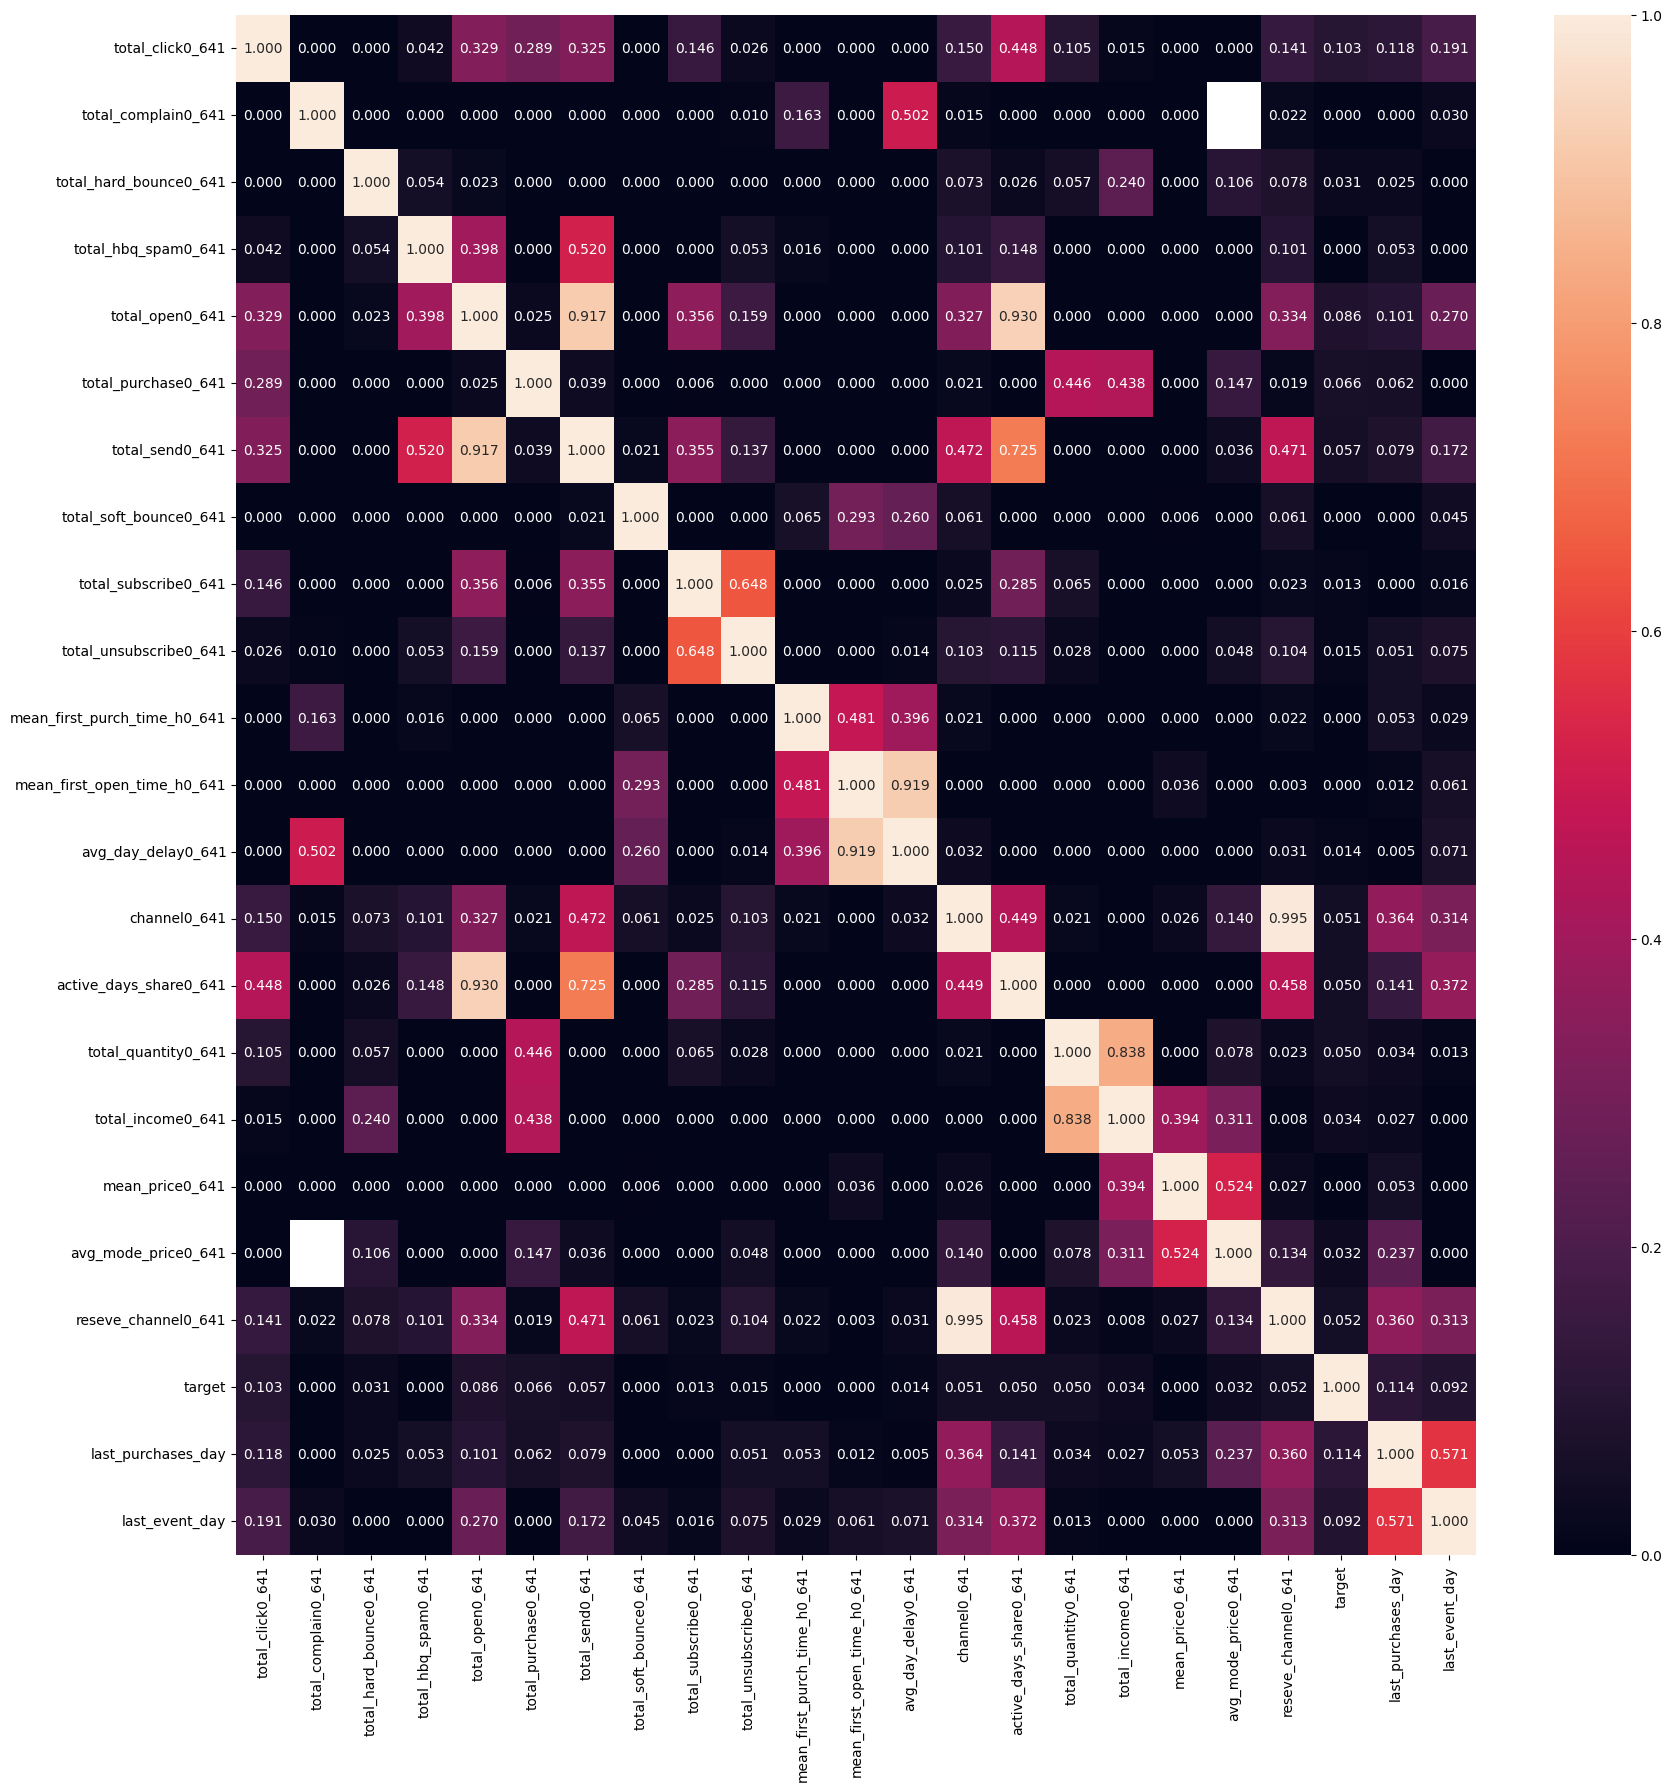

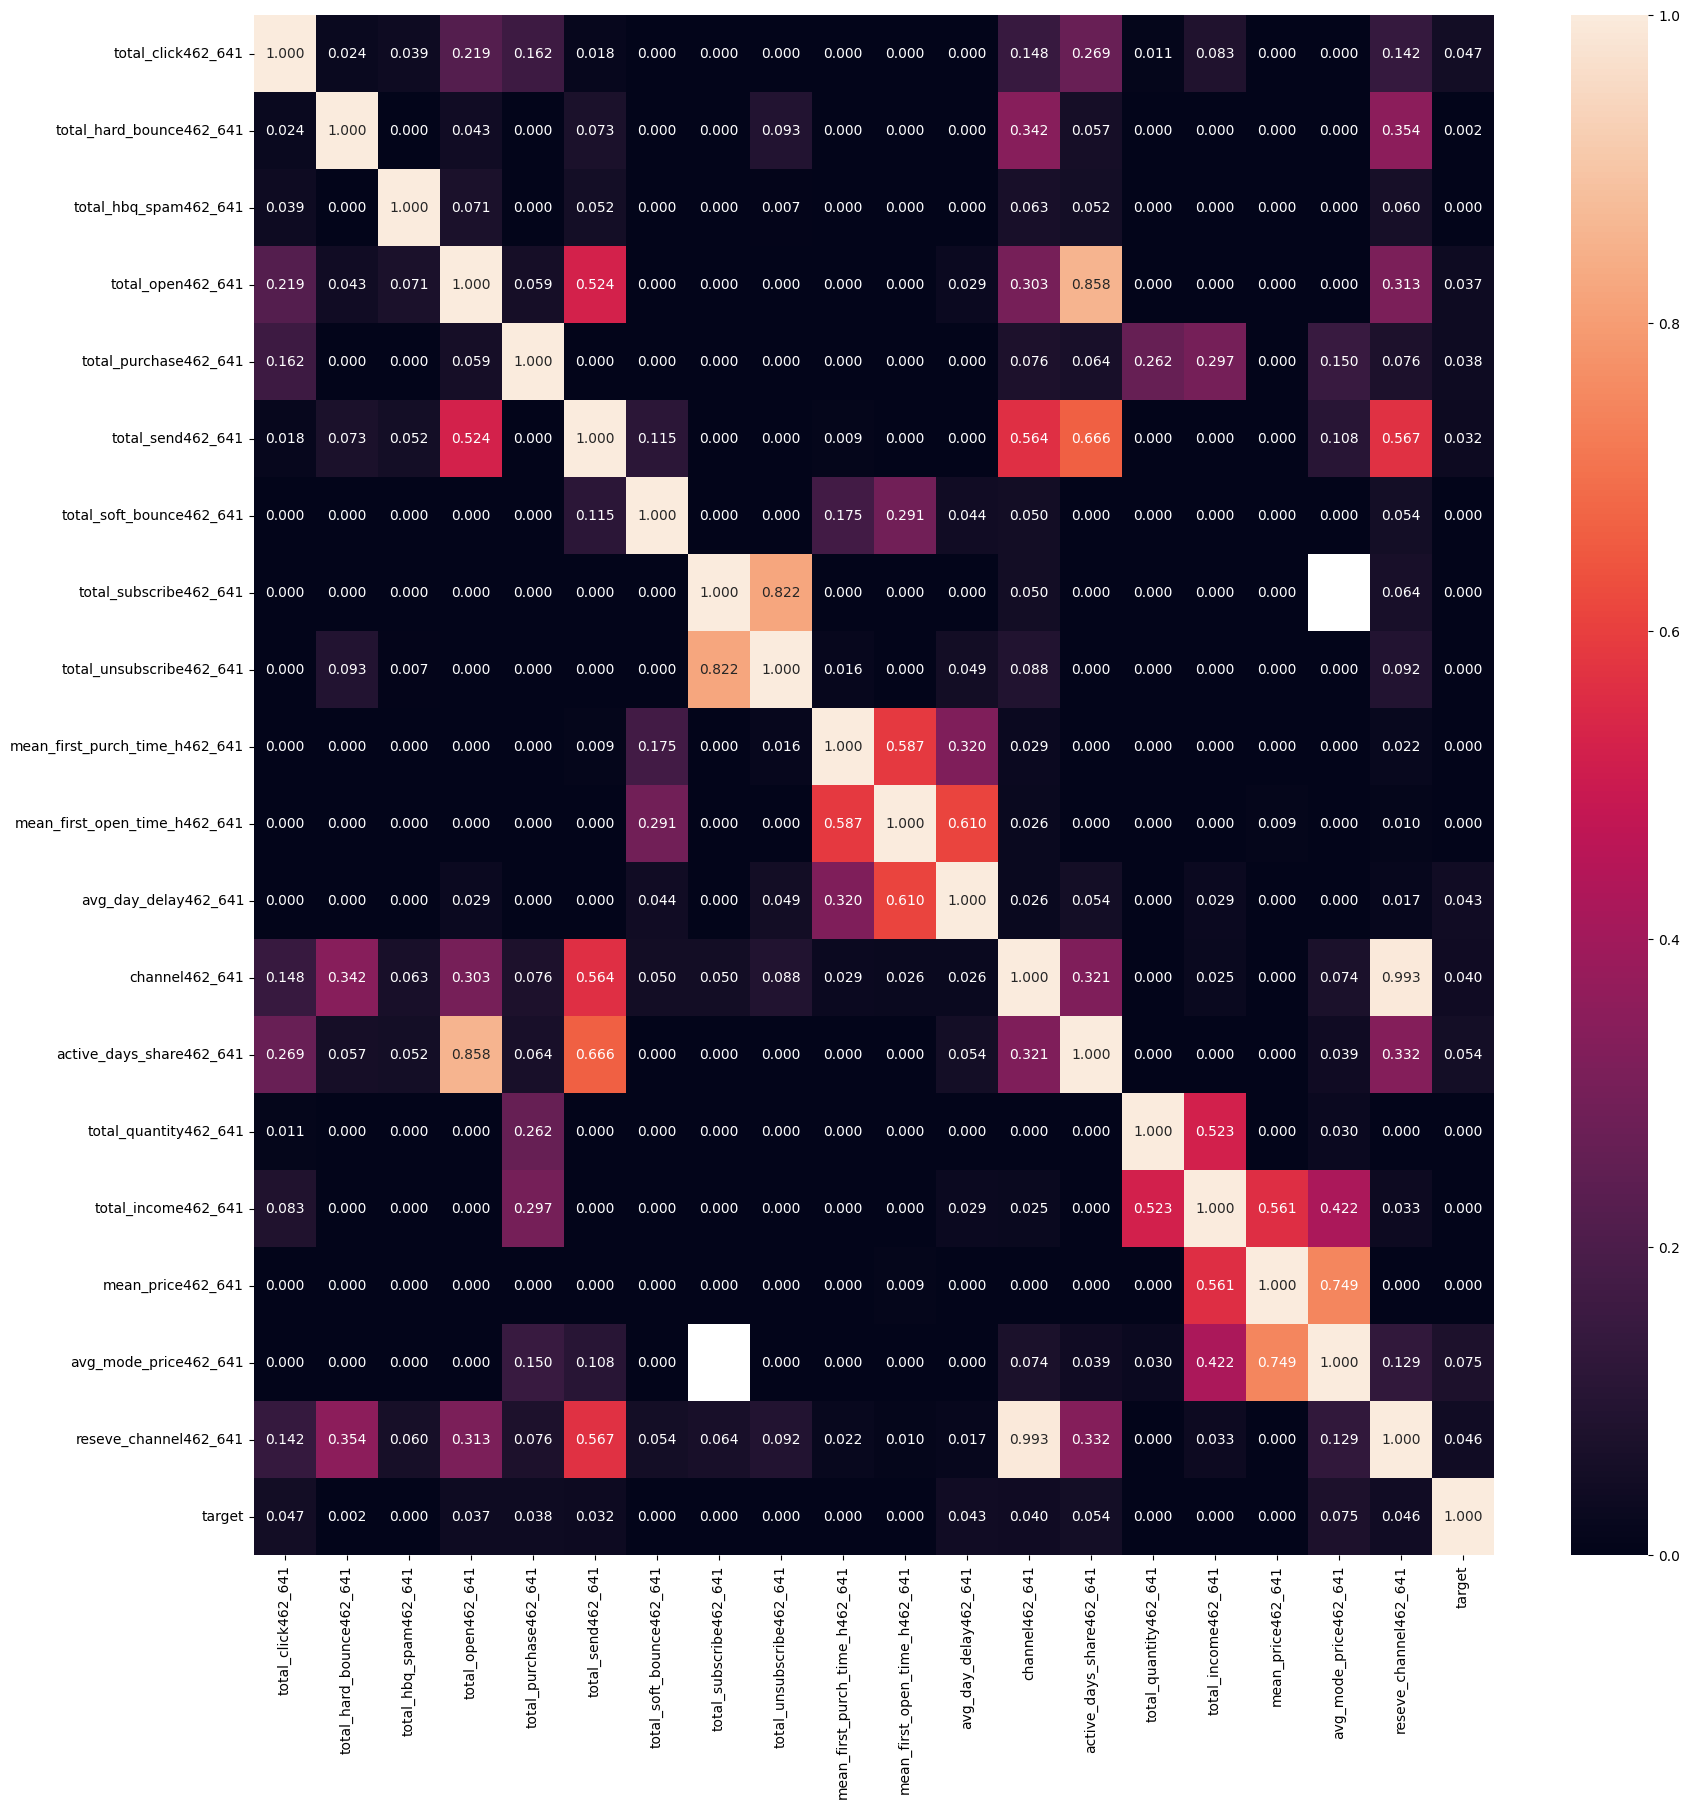

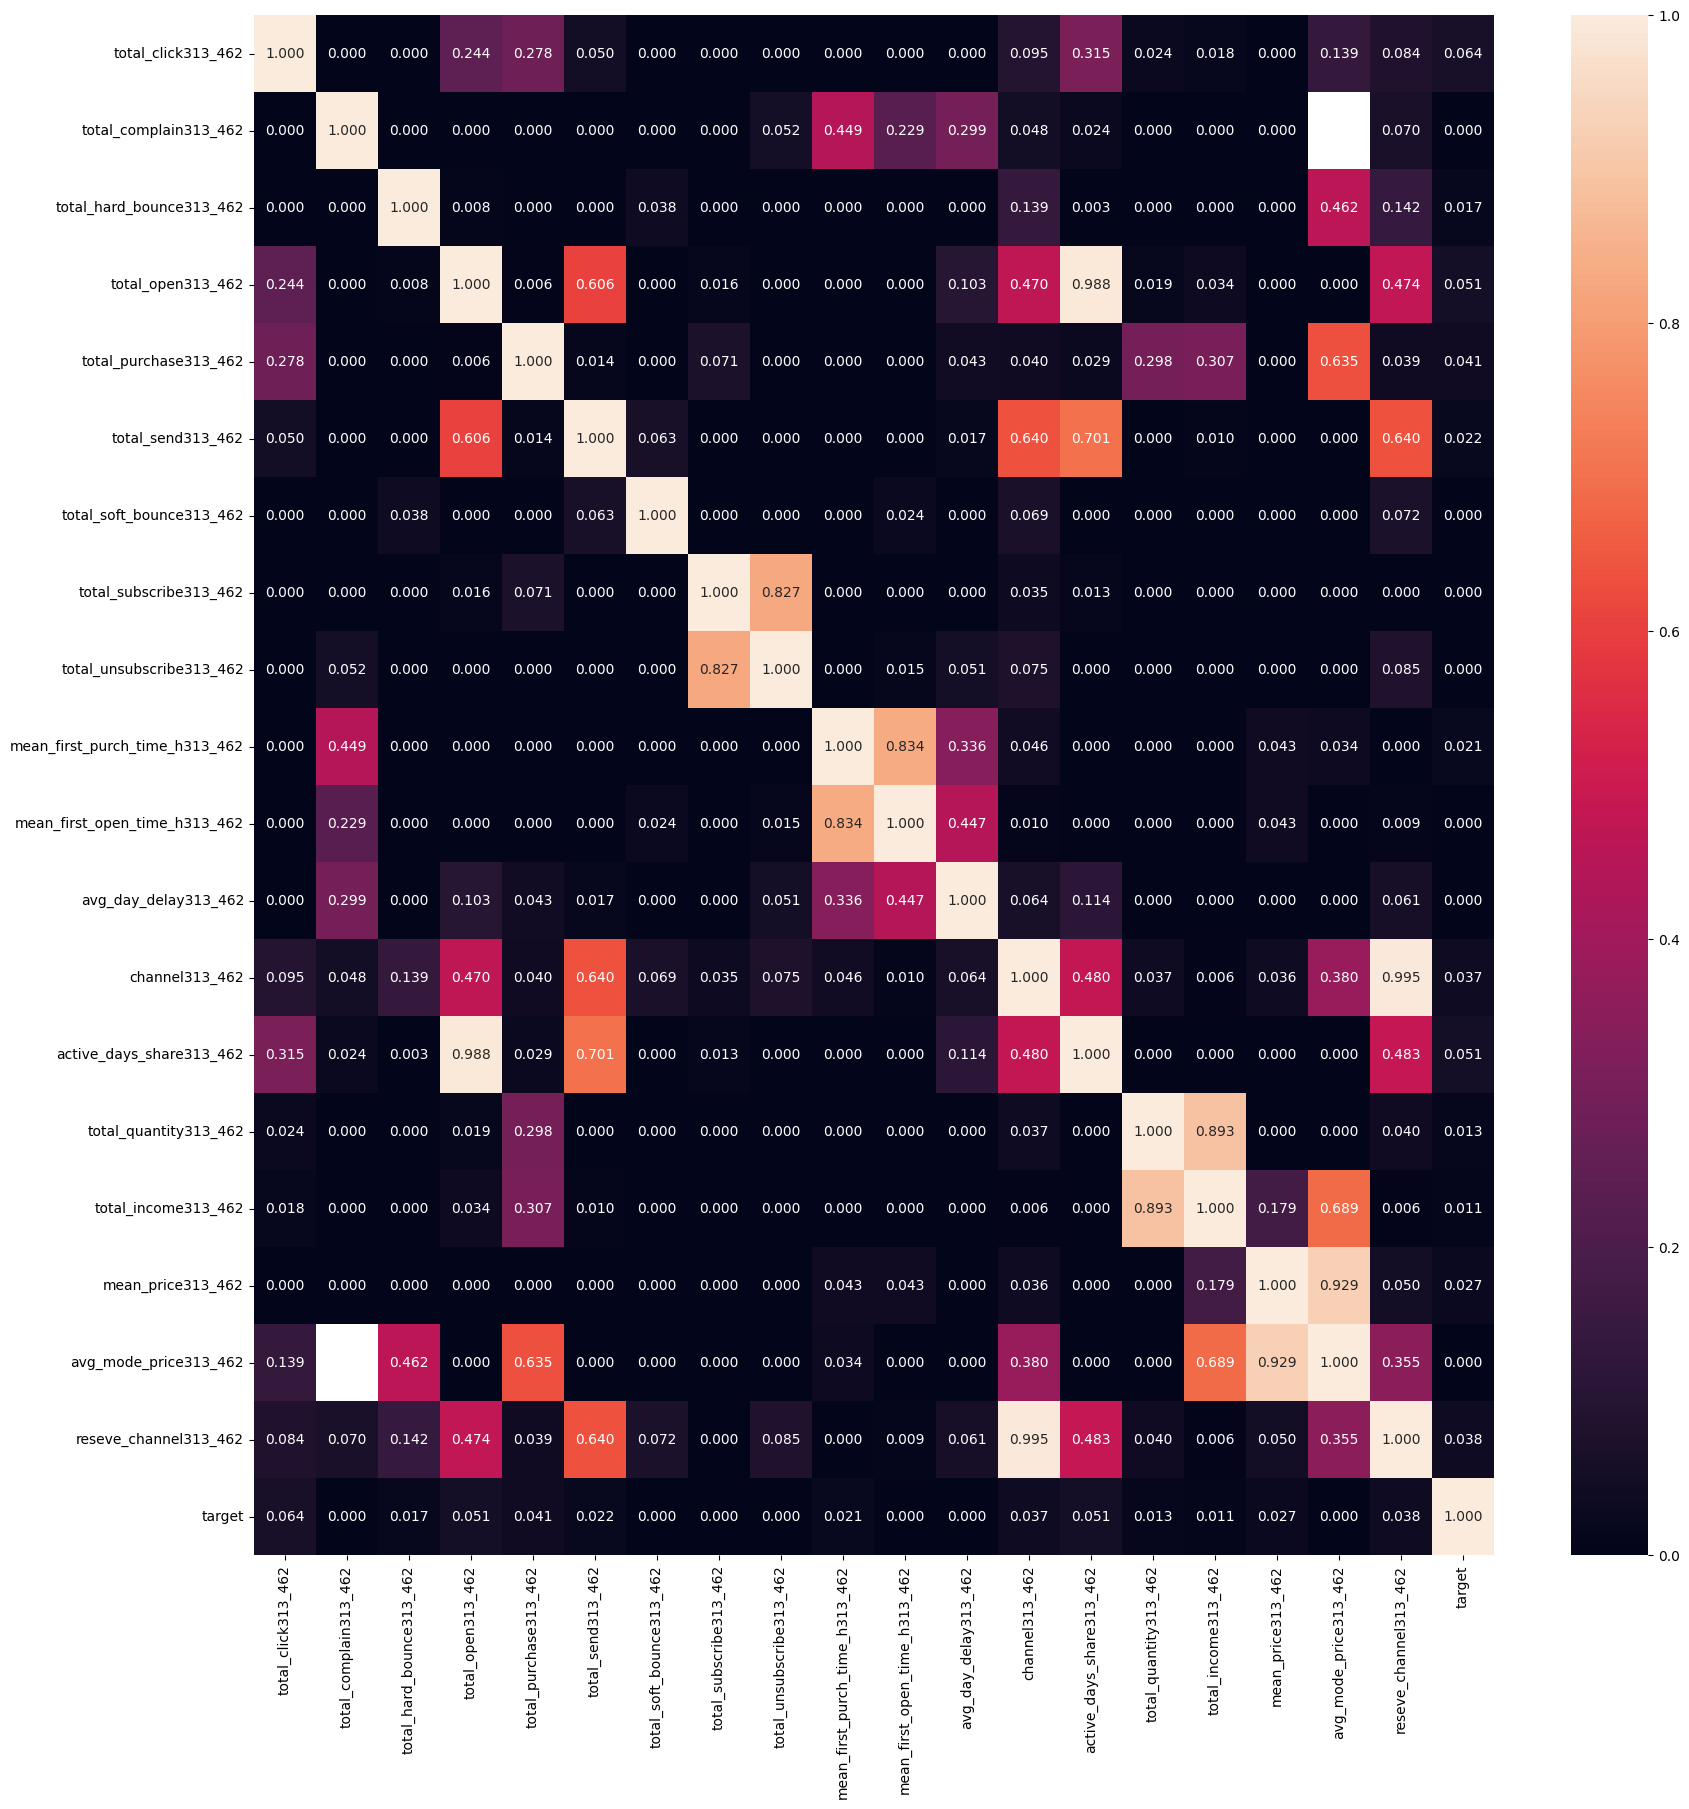

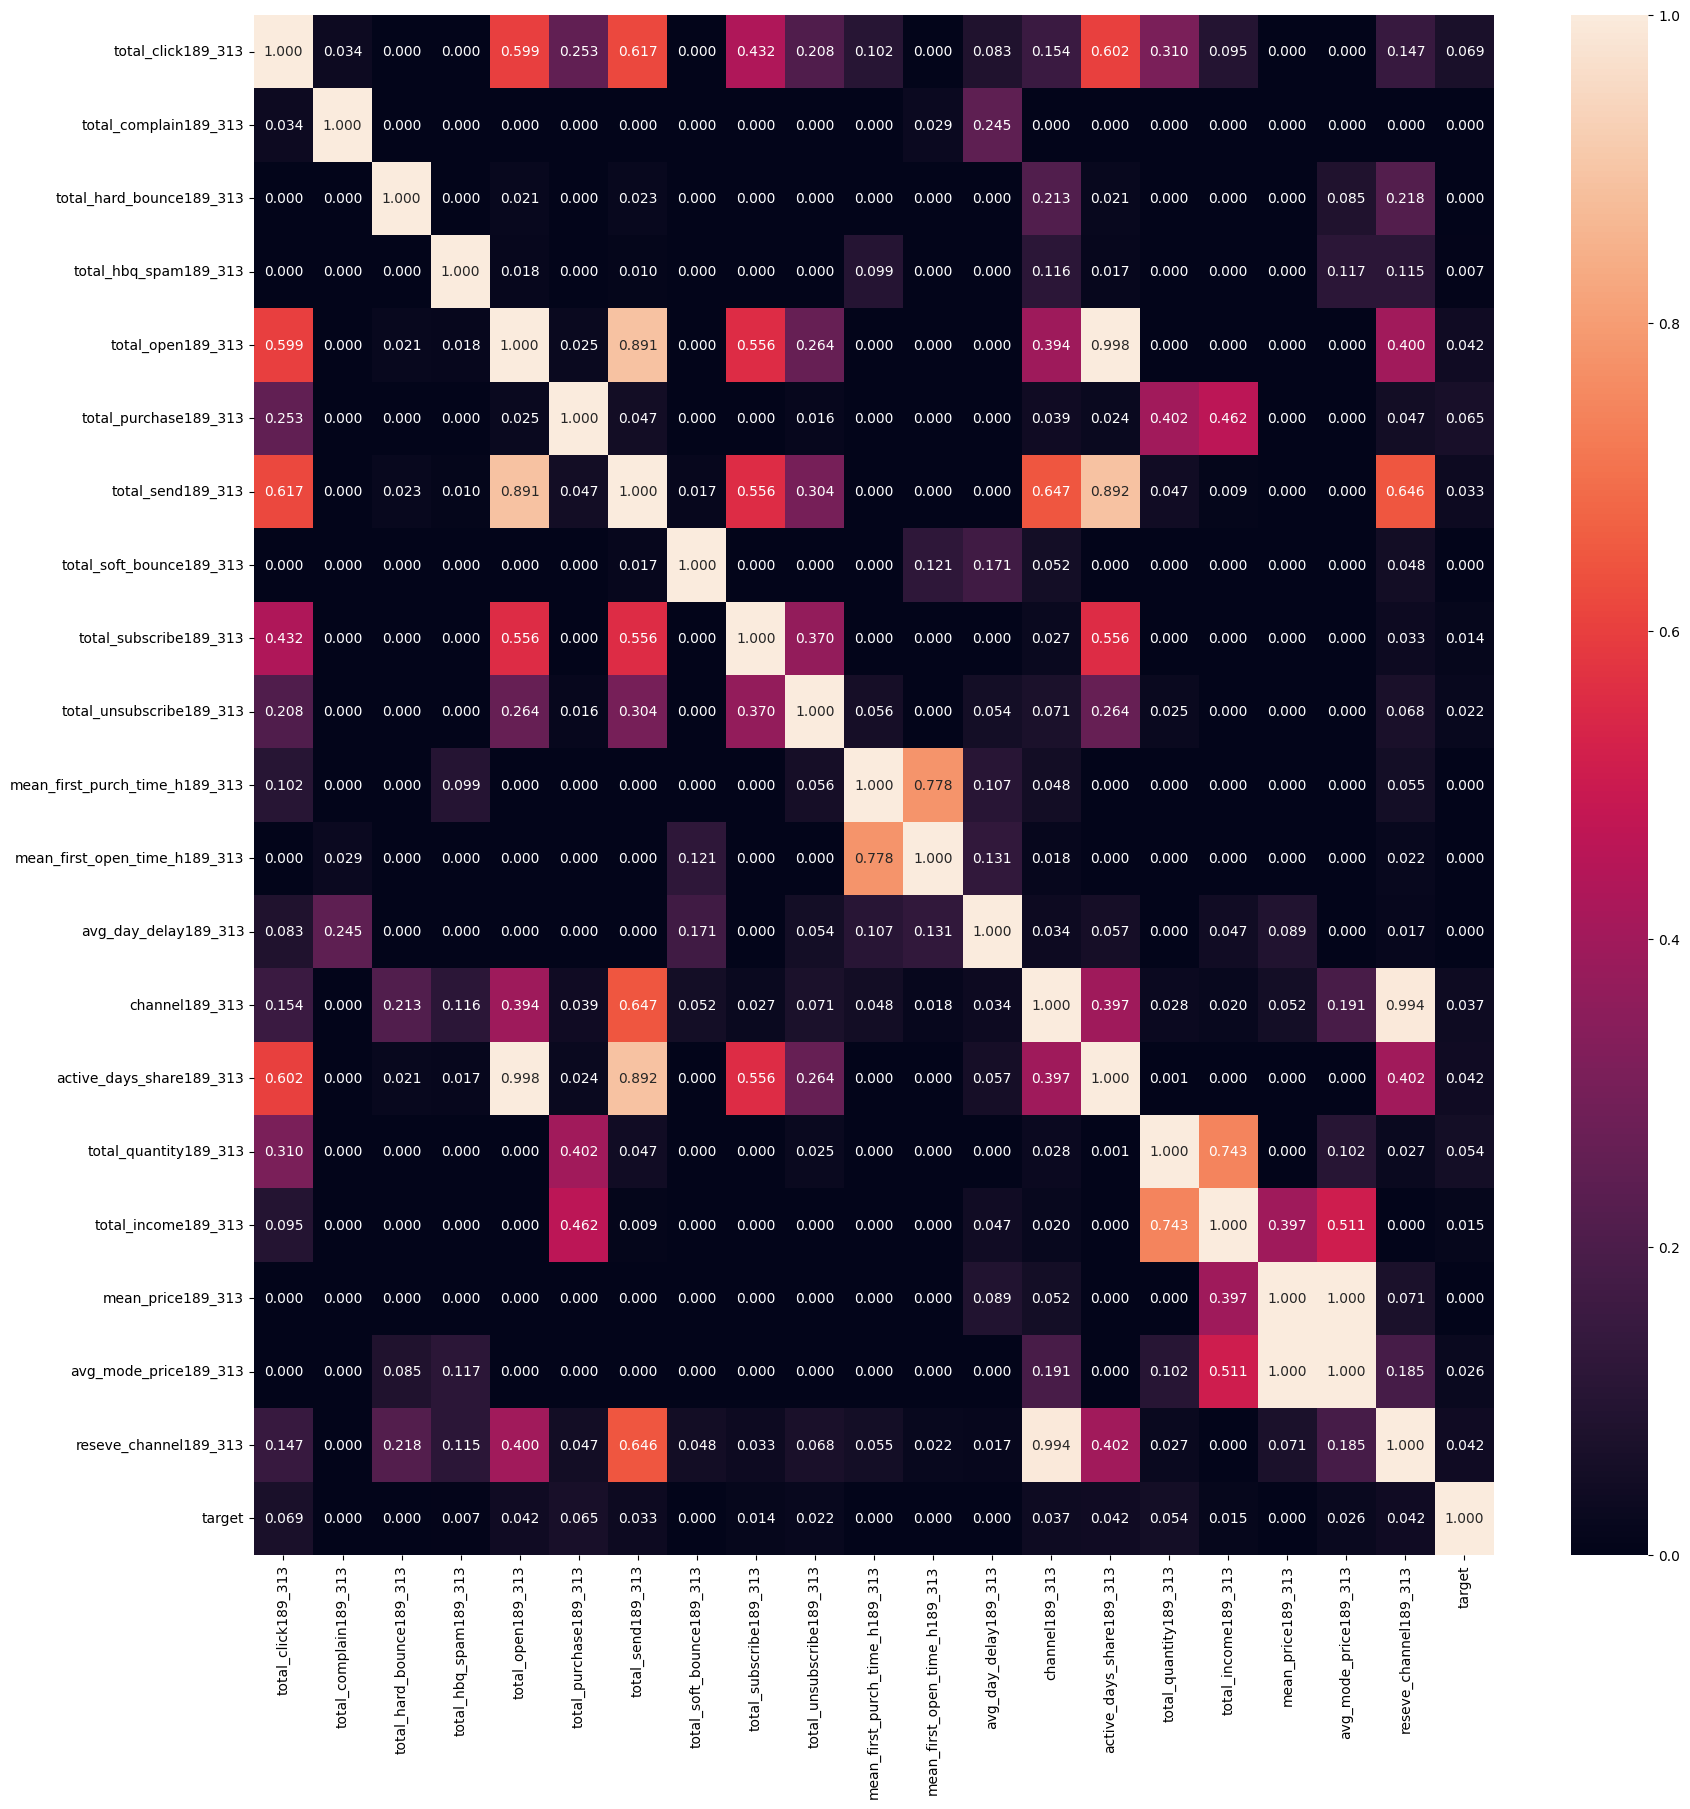

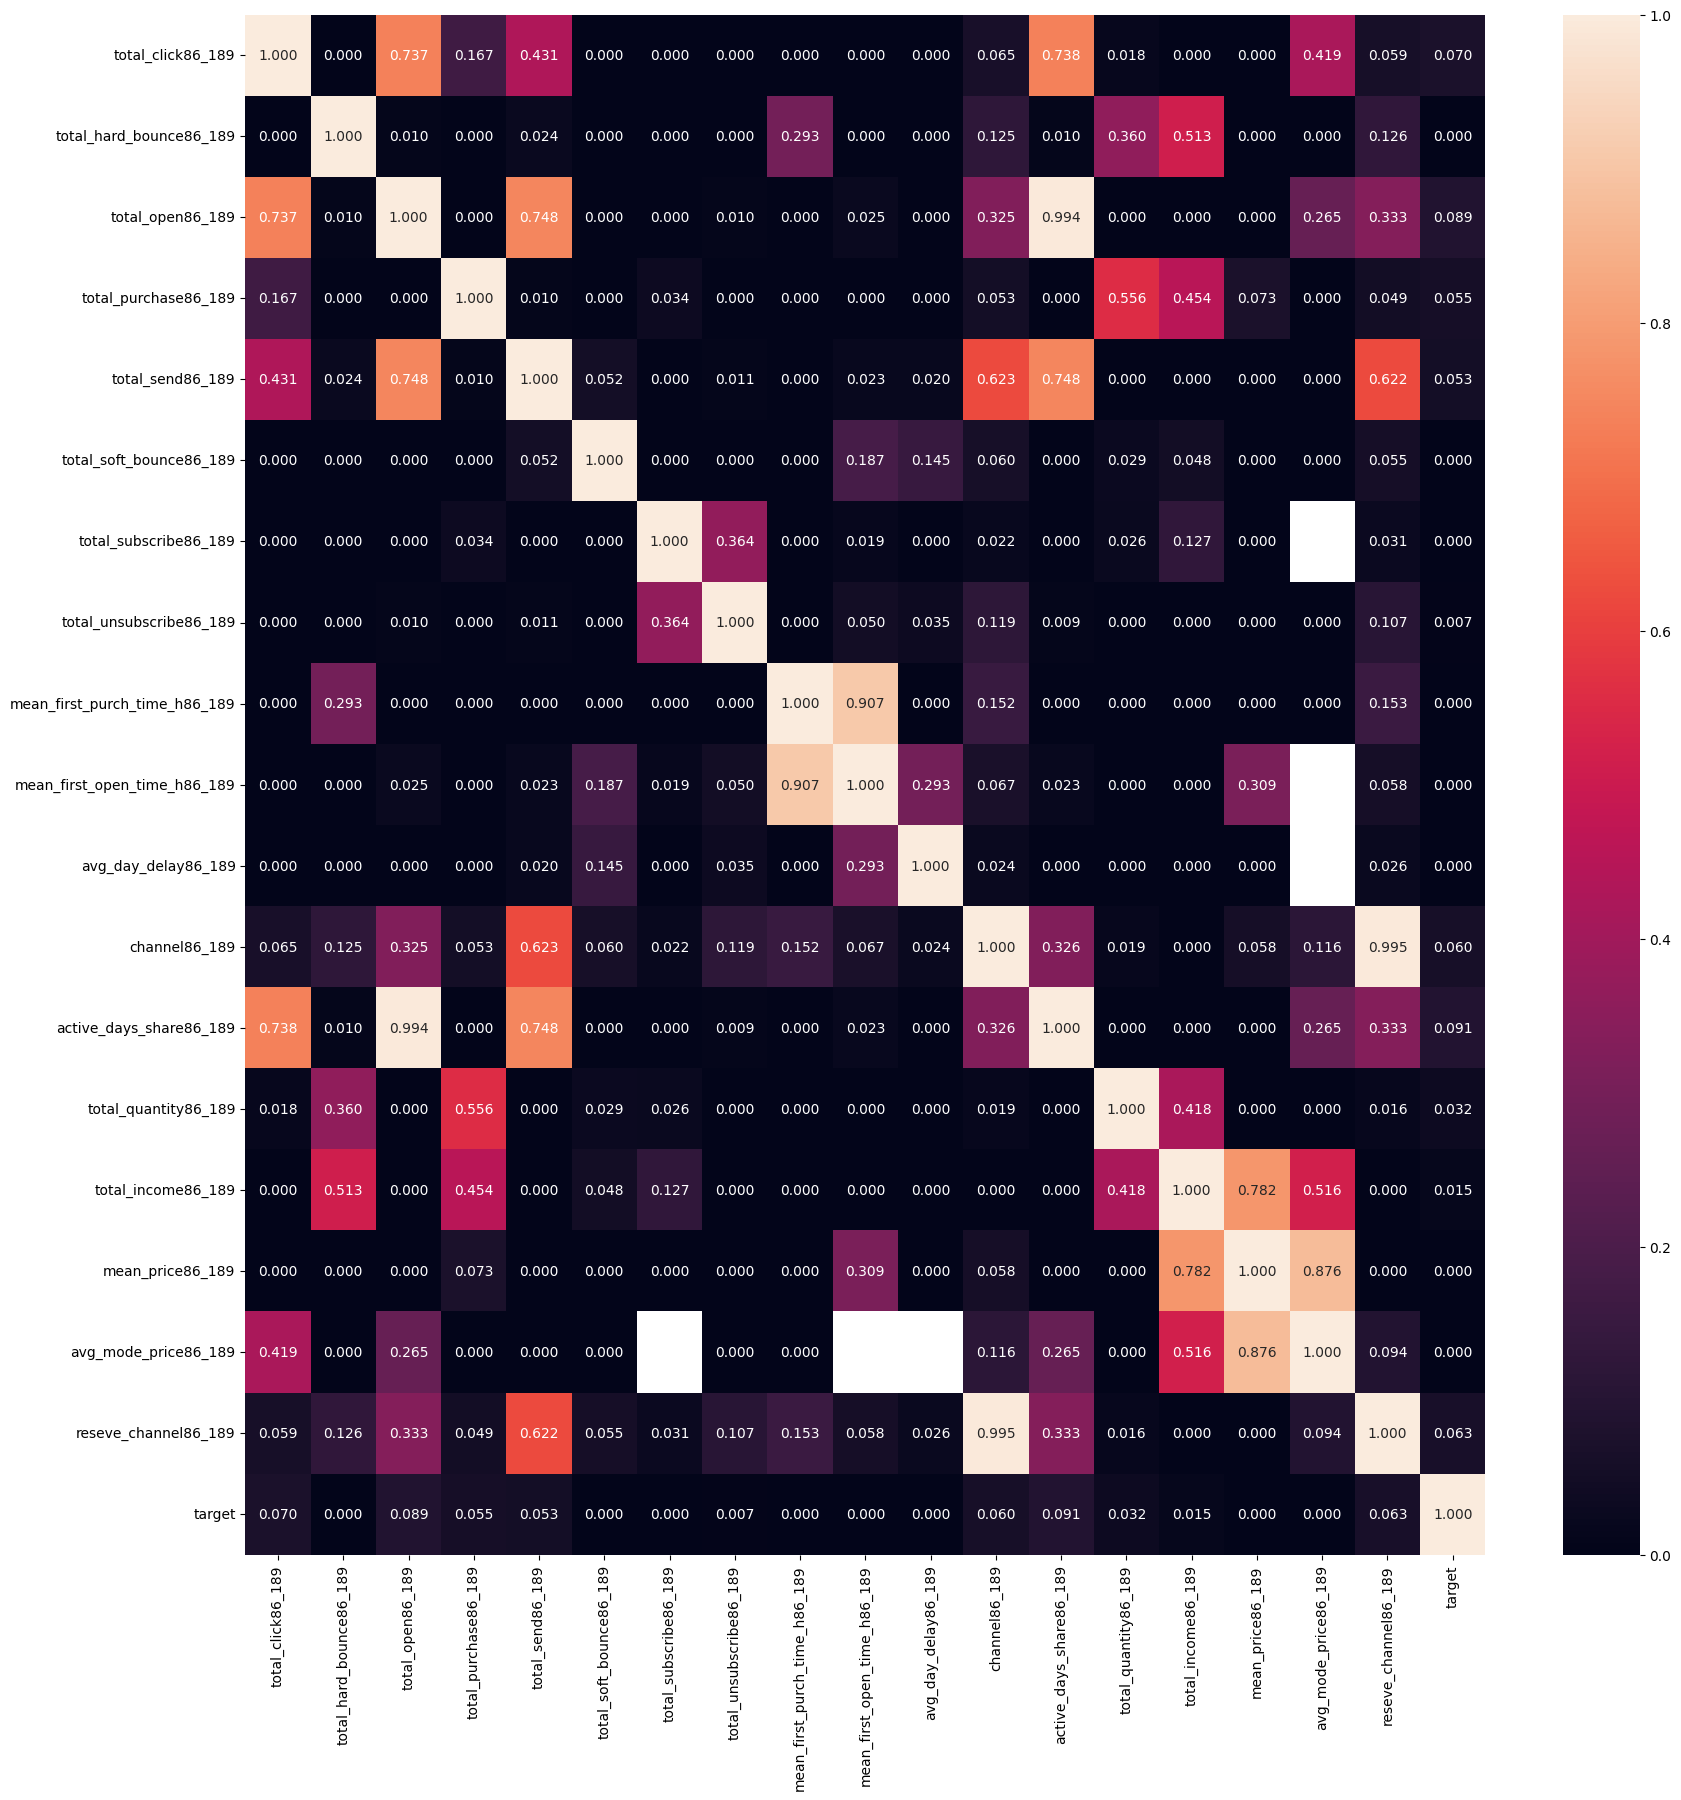

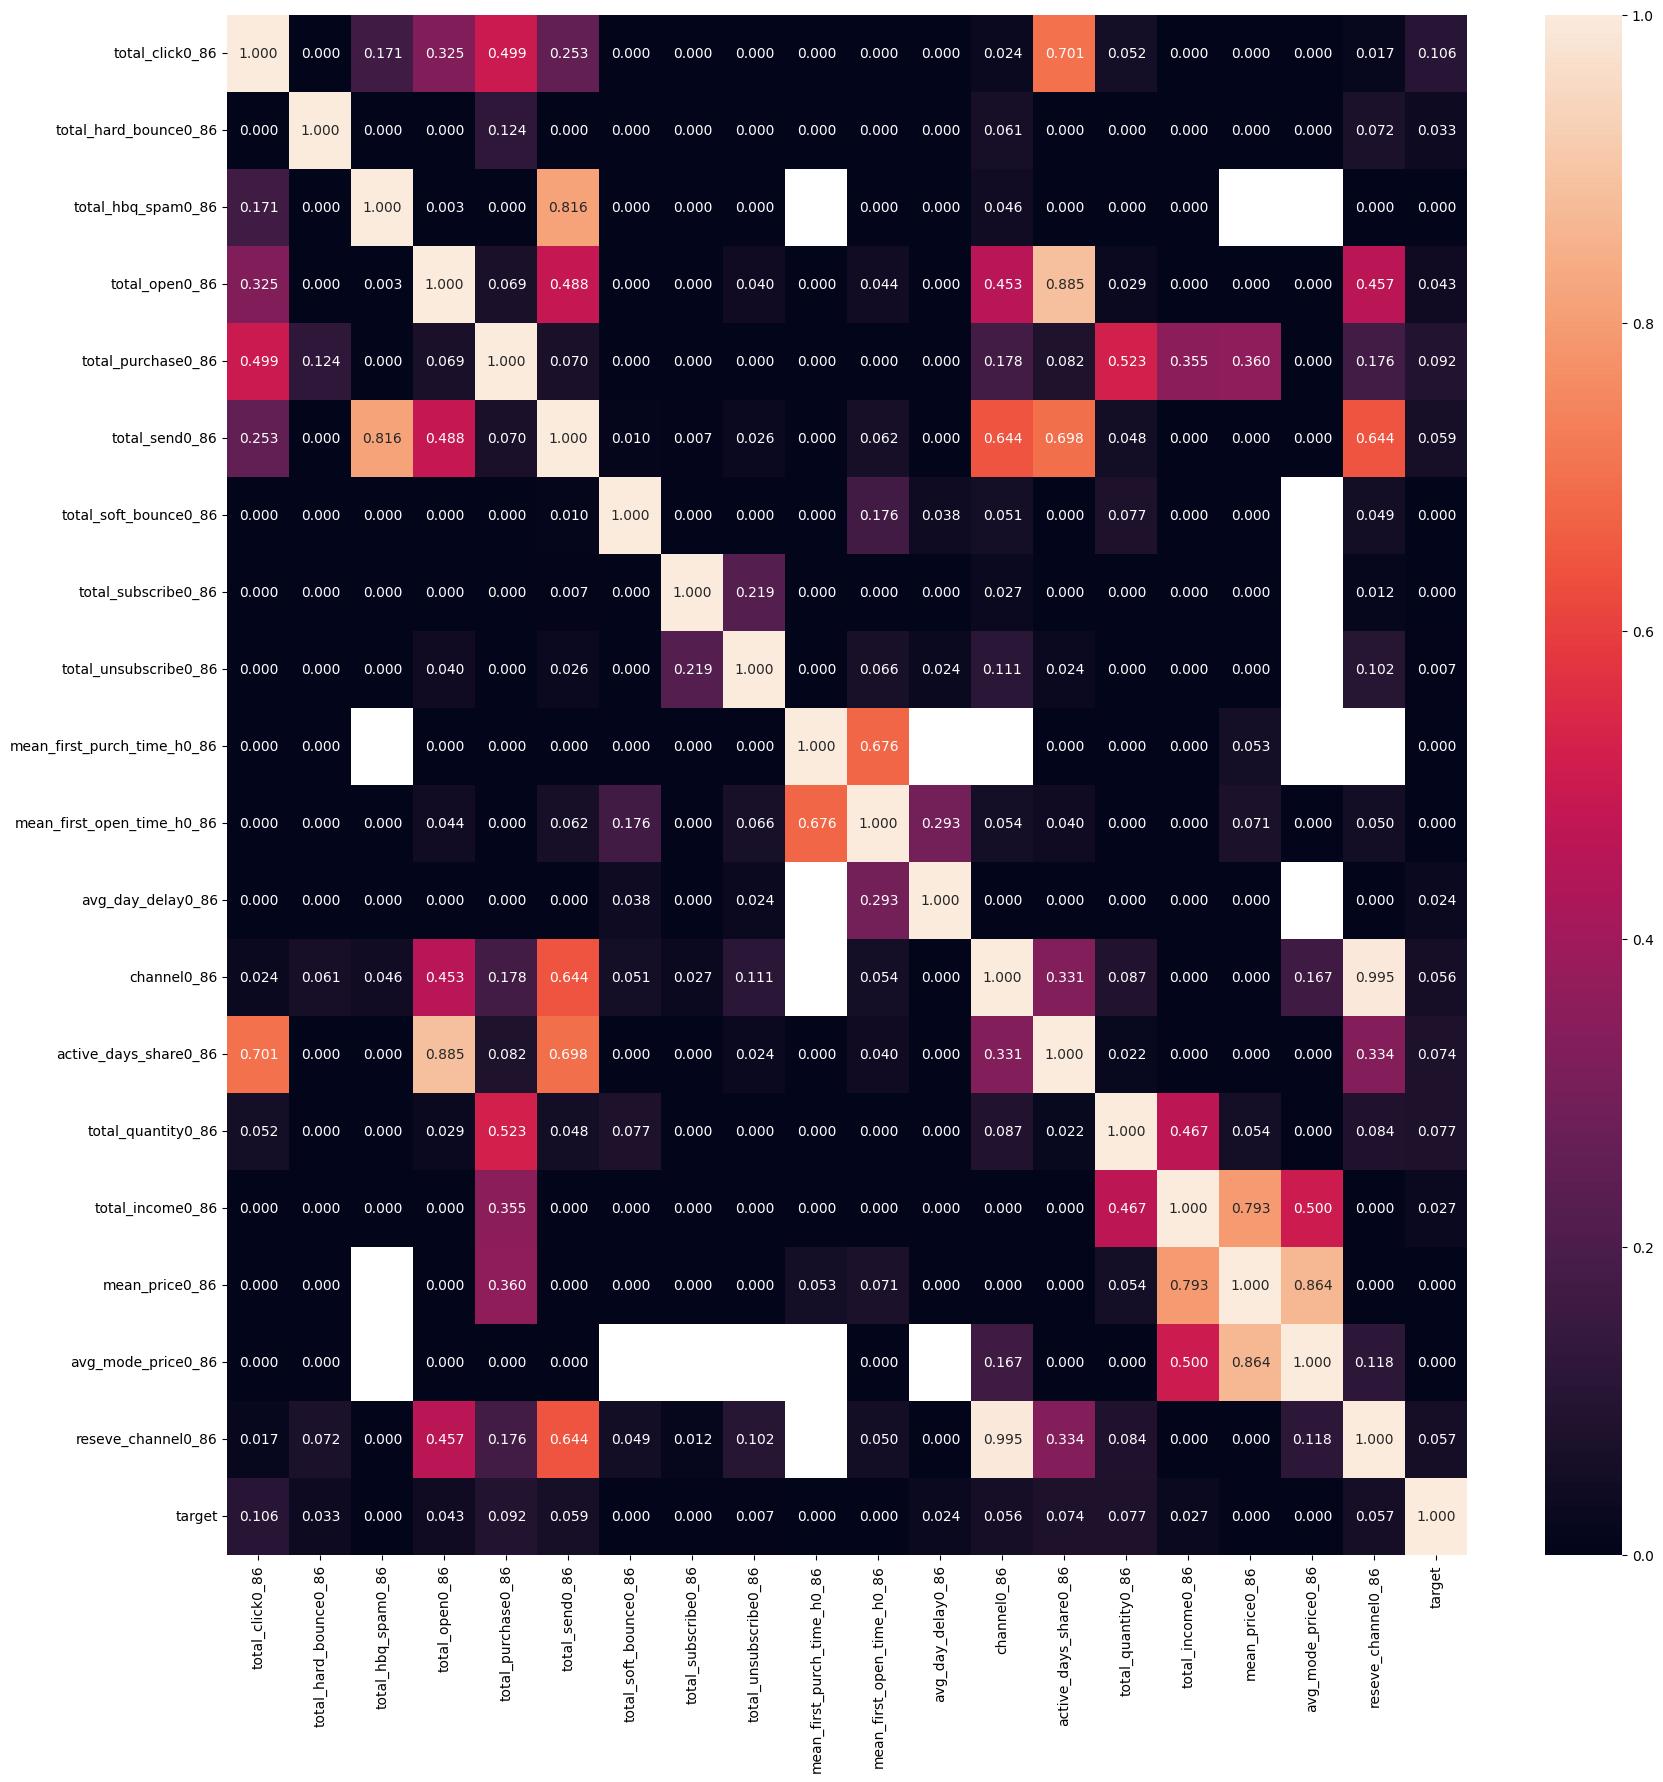

In [121]:
for i in time_segment_col:
    phik_matrix_range = data_ml[i].phik_matrix(interval_cols=i)
    plt.figure(figsize=(20, 20))
    sns.heatmap(phik_matrix_range, annot=True, fmt='.3f')

    
    
    
    

- Наблюдается низкая корреляция с таргетом, линейные модели скорее всего не подойдут 
- Была проведена попытка удаление признаков с 0 корреляцией с таргетом, однако это привело к ухудшению метрики

## Обучение моделей

### Конструирование пайплайна

In [122]:
num_cols  = data_ml.select_dtypes(['int','float']).columns.drop(['target'])

In [123]:
cat_cols  = 'categ'

In [124]:
RANDOM_STATE=42
TEST_SIZE=0.2

In [125]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ml.drop(['target','client_id'], axis=1),
    data_ml['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=data_ml['target']
)

In [126]:
from sklearn.preprocessing import FunctionTransformer

In [127]:
from sklearn.feature_selection import SelectFromModel

In [128]:
dict_vect_pipe = Pipeline([
    ('dict_vect', DictVectorizer(sparse=True)),
    #('select', SelectKBest(f_classif,k=10))
])

In [129]:
num_pipe=Pipeline(
        [
            (
            'simpleImputer_num',
             SimpleImputer(missing_values=pd.NA,strategy='constant', fill_value=0)
            ),
            (
            'scaler_num',
            StandardScaler()
            )
        ],
    
)

In [130]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', dict_vect_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ],
    remainder='passthrough'
) 

In [131]:
pipe_final = Pipeline(
    [  
        ('preprocessor', data_preprocessor),
        ('models',  CatBoostClassifier(verbose=0))
    ]
) 

### Выявление лучшей модели. Подбор гиперпараметров модели. 

In [132]:
# Отключение системных уведоблений при подборе гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [133]:
param_distribution_lgbm = {
    'models__n_estimators': IntDistribution(100, 500, step=20),
    'models__max_depth': IntDistribution(3, 5),
    'models__learning_rate': FloatDistribution(0.01, 0.2,log=True),
    'models__subsample': FloatDistribution(0.5, 1.0), 
    'models__reg_alpha': FloatDistribution(1e-4, 10.0,log=True),
    'models__reg_lambda': FloatDistribution(1e-4, 10.0,log=True),
    'models__num_leaves': IntDistribution(15, 255, step=8),
    'models__min_child_samples': IntDistribution(5, 100),
    'models__colsample_bytree': FloatDistribution(0.5, 1.0),
    'models__scale_pos_weight': FloatDistribution(0.5, 50, log=True),
    
}
param_distribution_XGB = {
    'models__n_estimators': IntDistribution(100, 500, step=20),
    'models__max_depth': IntDistribution(3, 12),
    'models__learning_rate': FloatDistribution(0.01, 0.1,log=True),
    'models__subsample': FloatDistribution(0.5, 1.0),
    'models__colsample_bytree': FloatDistribution(0.5, 1.0),
    'models__reg_alpha': FloatDistribution(1e-4, 10.0,log=True),
    'models__reg_lambda': FloatDistribution(1e-4, 10.0,log=True),
    'models__scale_pos_weight': FloatDistribution(0.5, 50, log=True),
}
param_distribution_CatBoost = {
    'models__iterations': IntDistribution(100, 1000, step=50),        
    'models__depth': IntDistribution(3, 12),                          
    'models__learning_rate': FloatDistribution(0.01, 0.3, log=True),   
    'models__l2_leaf_reg': FloatDistribution(1e-3, 10.0, log=True),    
    'models__bagging_temperature': FloatDistribution(0.0, 1.0),       
    'models__random_strength': FloatDistribution(0.0, 2.0),            
    'models__scale_pos_weight': FloatDistribution(0.5, 50, log=True),  
    'models__border_count': IntDistribution(32, 255),                  
}


In [134]:
models=[LGBMClassifier(random_state=RANDOM_STATE,verbose=-1),
       XGBClassifier(random_state=RANDOM_STATE)]
models_names=['LGBM','XGB']

param_distribution=[param_distribution_lgbm,
                    param_distribution_XGB]
iterations = [50, 50,50]

all_distributions=list(zip(models,models_names,param_distribution,iterations))

In [135]:
def trial_callback(study, trial):
    pbar.update(1)
    pbar.set_postfix({"current_value": trial.value})

In [137]:
results = []
for model, model_name, param, iteration in all_distributions:
    Pipe = deepcopy(pipe_final)
    Pipe.set_params(models=model)
    oscv = OptunaSearchCV(
        estimator=Pipe,
        param_distributions=param,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        cv=5,
        scoring='roc_auc',
        n_trials=iteration,
        verbose=0,
        callbacks=[trial_callback]
    )
    try:
        pbar = tqdm(total=iteration, desc="Fitting trials {0}".format(model_name))
        oscv.fit(X_train,y_train)
        results.append((model_name, oscv))
    finally:
        pbar.close()


Fitting trials XGB: 100%|██████████████████████████████████████████| 50/50 [17:50<00:00, 21.42s/it, current_value=0.75]


In [138]:
for i in results:
    display(i[0])
    display(pd.DataFrame(i[1].cv_results_).sort_values(by='mean_test_score',ascending=False).head(5))

'LGBM'

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
48,8.893015,5.808946,0.866049,0.690758,0.745665,0.806839,0.729099,0.733571,0.756181,0.754271,0.027940
0,20.099559,2.999784,2.851517,0.916353,0.743201,0.798765,0.733273,0.736768,0.752859,0.752973,0.023846
44,18.807431,4.196387,2.771847,0.990046,0.745218,0.803219,0.735236,0.729139,0.751573,0.752877,0.026341
18,22.473421,0.775039,3.221253,0.701408,0.746860,0.800660,0.732919,0.729681,0.753575,0.752739,0.025519
45,18.011427,4.190404,2.138412,0.983671,0.741880,0.796515,0.734501,0.729994,0.755786,0.751735,0.024035


'XGB'

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
29,40.161737,3.353937,0.706081,0.202396,0.741407,0.804400,0.739774,0.746175,0.758721,0.758096,0.024086
34,45.367842,3.782335,1.131229,0.305351,0.738865,0.802896,0.739988,0.745613,0.755262,0.756525,0.023901
33,45.225636,2.615729,0.996823,0.246438,0.738645,0.803122,0.739819,0.744605,0.756248,0.756488,0.024134
32,46.000026,2.752381,0.963007,0.501276,0.738076,0.801660,0.740309,0.745312,0.756760,0.756424,0.023521
28,39.362529,1.177398,0.990949,0.369522,0.738252,0.803219,0.741245,0.742646,0.756442,0.756361,0.024250


In [140]:
best_oscv=results[1][1]

In [142]:
best_model=best_oscv.best_estimator_.named_steps["models"]
best_est=best_oscv.best_estimator_
final_proc = best_oscv.best_estimator_.named_steps['preprocessor']

In [143]:
predict=best_est.predict_proba(X_test)[:,1]
roc_auc_score(y_test,predict)

0.778773671337015

Результат без отсеивания признаков

In [144]:
feat_imp = pd.DataFrame({
    "feature": final_proc.get_feature_names_out(),
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)


In [ ]:
feat_imp.head(50)

In [207]:
useful_feat=feat_imp.sort_values(by='importance',ascending=False)['feature'].head(450)

In [208]:
X_test_2=final_proc.transform(X_test)
X_test_2=pd.DataFrame(X_test_2.toarray(),columns=final_proc.get_feature_names_out())[useful_feat]
X_train_2=final_proc.transform(X_train)
X_train_2=pd.DataFrame(X_train_2.toarray(),columns=final_proc.get_feature_names_out())[useful_feat]




In [209]:
best_model.fit(X_train_2,y_train)
predict=best_model.predict_proba(X_test_2)[:,1]
roc_auc_score(y_test,predict)

0.7794496147814821

Итоговый результат

## Вывод по проекту




Проект показал, что даже при наличии **неполных и аномальных данных** можно построить работающую модель, способную с высокой точностью предсказывать вероятность покупки.

Модель достигла **ROC-AUC = 0.78** при целевом уровне **0.7**, что подтверждает её практическую ценность для задач **сегментации клиентов** и **повышения эффективности маркетинговых кампаний**.

Анализ данных выявил **системные несоответствия между источниками** (`messages`, `purchases`, `target`), указывающие на необходимость улучшения процессов сбора и хранения информации.  
Тем не менее, модели показали **устойчивость к ошибкам данных** благодаря предобработке, подбору гиперпараметров и использованию **бустинговых алгоритмов**.

---

 **Результаты проекта могут быть использованы для:**
- приоритизации клиентов по вероятности покупки;  
- более точного планирования рекламных кампаний;  
- оптимизации бюджета рассылок.